In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
#from colour import Color
import seaborn as sn
import pandas as pd
from matplotlib.patches import Rectangle
 
import pingouin as pg
from scipy import stats
import random
import math
import statsmodels.api as sm 
from statsmodels.formula.api import ols

def outputIconForStats(pval):
    if pval <= 0.05:
        icon = '*'
    else:
        icon = ' '
    return icon

def ConvertDictToDataFrame(datadict):
    #data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}    
    X = []
    Y = []
    for key in datadict.keys():
        for ele in datadict[key]:
            X.append(ele)
            Y.append(key)
        
    data = {'X': X, 'group': Y}
    df = pd.DataFrame.from_dict(data)
    return df

def ComputeStats_group1(d_cond):
    #compare against chance
    r_data = np.random.choice([0, 1], size=len(d_cond), p=[.5, .5])
    result = pg.ttest(d_cond, r_data, correction=True) 
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof

def ComputeStats_group2(data_d1, data_d2):
    result = pg.ttest(data_d1, data_d2, correction=True) 

    # reporting format in Turing project (p < 10−15, two-tailed t-test, t = 8.5, df = 478)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof
    
def ComputeStats_group3(data_dict):
    df = ConvertDictToDataFrame(data_dict)
    #print(df)
    mod = ols('X ~ group', data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    
    #A one-way ANOVA revealed that there [was or was not] a statistically significant difference in [dependent variable] 
    #between at least two groups (F(between groups df, within groups df) = [F-value], p = [p-value]).
    BetweenGP_df = aov_table.df.group
    WithinGP_df = aov_table.df.Residual
    Fval = aov_table.F.group
    pval = aov_table['PR(>F)'].group
    icon = outputIconForStats(pval)
    return icon, BetweenGP_df, WithinGP_df, Fval, pval

def displayStats_group12(pval, Tval, dof):    
    if pval < 0.05:
        print('There is difference between data1 and data2.')
        if pval > 0.01 and pval < 0.05:
            print("(p < 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.001 and pval <= 0.01:
            print("(p < 0.01, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.0001 and pval <= 0.001:
            print("(p < 0.001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        else:
            print("(p < 0.0001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
    else:
        print('There is NO difference between data1 and data2.')
        print("(p > 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")

        
def displayStats_group3(BetweenGP_df, WithinGP_df, Fval, pval):    
    print("F(" + str(BetweenGP_df) + ", " + str(WithinGP_df) + ") = " + str(Fval) +", p-val=" + str(pval))

    
def boostrap(data1, data2):
    import random
    import math
    store = []
    sample_mean = []
    if len(data1) < len(data2):
        SampleTimes = math.ceil(len(data1)/2)
        BootstrapTimes = len(data1)
    else:
        SampleTimes = math.ceil(len(data2)/2)
        BootstrapTimes = len(data2)
        
    print("bootstraptime",BootstrapTimes,"sampletime",SampleTimes)
    for i in range(BootstrapTimes):
        y1 = random.sample(data1, SampleTimes)
        #print(y1)
        y2 = random.sample(data2, SampleTimes)
        #print(y2)
        y_comb = y1+y2
        #print(y_comb)
        sample_mean.append(np.mean(np.array(y_comb), axis=0))
    
    stdval = np.std(np.array(sample_mean), axis=0)
    return stdval

def ConcatData(data1, data2):
    import random
    import math
    
    #print(data1)
    #print(data2)
    if len(data1) < len(data2):        
        BootstrapTimes = len(data1)
    else:        
        BootstrapTimes = len(data2)
    
    #print(BootstrapTimes)
    y1 = random.sample(data1, BootstrapTimes)
    #print(y1)
    y2 = random.sample(data2, BootstrapTimes)
    #print(y2)
    y_comb = y1+y2
    y_comb = np.array(y_comb)        
    return y_comb


def ComputeBarStdConfMat(contents):
    modelist = ['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    print(modelist)
    
    #initialize matrix of absolute counts   
    result = {'human':0, 'countH':0, 'machine':0, 'countM': 0, 'result_H':[], 'result_M':[]}
    for modelname in modelist:
        result[modelname] = 0
        result['count_'+modelname] = 0
        result['result_'+modelname]=[]
    #print(result)

    # Iterating over keys
    for trialid in contents:
        trialinfor = contents[trialid]['trialData']

        if trialinfor['groundtruth'] == 'human':
            result['countH'] = result['countH'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['human'] = result['human'] + 1
                result['result_H'].append(1)
            else:
                result['result_H'].append(0)
                
        else:
            result['countM'] = result['countM'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['machine'] = result['machine'] + 1
                result['result_M'].append(1)
            else:
                result['result_M'].append(0)
                
            modelname = trialinfor['machine_groundtruth']
            result['count_'+modelname] = result['count_'+modelname] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result[modelname] = result[modelname] + 1
                result['result_' + modelname].append(1)
            else:
                result['result_' + modelname].append(0)
                
    #print(result)

    #compute confusion matrix
    result_conf_mat = np.zeros((2+len(modelist),2),'float32')
    result_conf_mat[0][0] = result['human']/result['countH']
    result_conf_mat[0][1] = (result['countH'] - result['human'])/result['countH']  
    result_conf_mat[1][0] = (result['countM'] - result['machine'])/result['countM']
    result_conf_mat[1][1] = result['machine']/result['countM']

    for i, modelname in enumerate(modelist):
        result_conf_mat[i+2][0] = (result['count_'+modelname] - result[modelname])/result['count_'+modelname]
        result_conf_mat[i+2][1] = result[modelname]/result['count_'+modelname]

    result_conf_mat = np.around(result_conf_mat, decimals=2)
        
    stdmodelist = ['M', 'git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    modelist_stats = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    top1 = []
    top1_std = []
    resultFlist = {}
    data1tot = result['result_H']
    for i in range(1+len(modelist)):
        #print(i)
        top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
        # compute bootstrap accuracy
        # compute and save std for top1 accuracy
        top_std_AI = boostrap(result['result_H'], result['result_' + stdmodelist[i]])
        top1_std.append(top_std_AI)
        data2tot = result['result_' + stdmodelist[i]]
        #resultFlist[modelist_stats[i]] = np.concatenate((data1tot,data2tot))
        resultFlist[modelist_stats[i]] = ConcatData(data1tot,data2tot)
    #print(top1)
    
    return top1, top1_std, result_conf_mat, resultFlist


### plots for grouping demographic information
def plot_res_demographics(condition_chosen_list, TextFilePath, plotname,facebarcolor, condition_results):
    
    compiledAllConds = {}
    
    modelist = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    Pdata = {} #data stored for computing statistics 
    #initialize PData
    for i in range(0,len(modelist)):
        Pdata[modelist[i]] = {}
    
    for condition_chosen in condition_chosen_list:
        
        top1, top1std, result_conf_mat, resultFlist = ComputeBarStdConfMat(condition_results[condition_chosen])
        
        for i in range(0,len(modelist)):
            Pdata[modelist[i]][condition_chosen] = resultFlist[modelist[i]]
        
#         #compute barplot and errorbar of barplot
#         top1 = []
#         top1std = []

#         #compute confusion matrix
#         result_conf_mat = 

        compiledAllConds[condition_chosen] = top1
        compiledAllConds[condition_chosen +'_std'] = top1std
    
    ### we have the compiled resutls now; lets calculate stats
    chancePval = []
    groupPval = []
    print(modelist)
    print()
    for i in range(0,len(modelist)):
        for condition_chosen in condition_chosen_list:        
            #compute against chance 50%
            d_cond = Pdata[modelist[i]][condition_chosen]
            icon, pval, Tval, dof = ComputeStats_group1(d_cond)
            chancePval.append(icon)
        if len(Pdata[modelist[i]].keys()) == 2:
            data_d1 = Pdata[modelist[i]][condition_chosen_list[0]]
            data_d2 = Pdata[modelist[i]][condition_chosen_list[1]]
            icon, pval, Tval, dof =  ComputeStats_group2(data_d1, data_d2)
            groupPval.append(icon)
        elif len(Pdata[modelist[i]].keys()) >= 3: 
            icon, BetweenGP_df, WithinGP_df, Fval, pval = ComputeStats_group3(Pdata[modelist[i]])
            groupPval.append(icon)
        else:
            print("Oops!  This should NOT happen...")
    
    #data
    #x-axis
    years = list(range(1, len(modelist)))
    strtask = modelist
    #print(years)
    #print(strtask)

    # Figure Size
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(strtask))  # the label locations
    point_x = [] #for plotting stats * or n.s.
    
    width = 0.2  # the width of the bars
    if len(condition_chosen_list) == 2:
        multiplier = -0.5 #len(condition_chosen_list)
    else:
        multiplier = -1 #len(condition_chosen_list)
    #ngroups = len(condition_chosen_list)

    ax.add_patch(Rectangle((-0.5, 0.45), len(modelist), 0.1,facecolor='yellow'))
    #bar chart properties
    #ax.bar(strtask, top1, color ='black', width = 0.3)    

    for ind, condition_chosen in enumerate(condition_chosen_list):
    #for condition_chosen in condition_chosen_list:
    #for attribute, measurement in compiledAllConds.items():
        measurement = compiledAllConds[condition_chosen]
        measurement_std = compiledAllConds[condition_chosen + '_std']
        attribute = condition_chosen
        
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, yerr= measurement_std, width = width,alpha=0.5,
                       label=attribute, edgecolor='black', color=facebarcolor[ind], ecolor='black')#,
                       #align='center', alpha=0.5, ecolor='black', capsize=10,color ='black')
        #ax.bar_label(rects, padding=3)
        point_x.extend( (x+offset).tolist() )
        multiplier += 1
    
#     ax.bar(strtask, top1, yerr=top1std,
#        align='center', alpha=0.5, ecolor='black', capsize=10,
#        color ='black', width = 0.3)

    ########## ready for plotting stats
    #print(point_x)
    ###### getting statistics
    #chancePval, groupPval = getStats(condition_chosen_list, TextFilePath)
    point_x.sort(reverse=False)
    #print(point_x)
    for i, p in enumerate(point_x):        
        ax.text(p, .7, chancePval[i], fontsize=8, transform=ax.get_xaxis_transform())
    
    ax.set_xticks(x, strtask)
    ax.legend(loc='upper left', ncols=len(condition_chosen_list))

    ###### plot stats for each group of bars
    totalPx = len(point_x)
#     print(totalPx)
#     print(point_x)
    count = 0
    for s1 in range(0,totalPx, len(condition_chosen_list)):
        center_x = 0
        for s2 in range(0,len(condition_chosen_list)):
            center_x = center_x + point_x[s1+s2]
        center_x = center_x/len(condition_chosen_list)
        starting_x = point_x[s1]
        ending_x = point_x[s1+len(condition_chosen_list)-1]
        plt.plot(   np.array([starting_x, ending_x]),
                           np.arange(2)*0+0.82, 'k', label='chance (50%)')
        ax.text(center_x, .8, groupPval[count], fontsize=8, transform=ax.get_xaxis_transform())
        count = count + 1
    
    ###### ending: plot stats for each group of bars
    
    plt.ylabel('Top-1 Accuracy')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

    plt.ylim(0.25, 1)
    #plt.xlim(0.5, len(years)+0.5)

    #draw chance 0.5 
    chancex =np.arange(len(years)+2)-0.5
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    #plt.legend()

    fig.tight_layout()

    fig.set_figwidth(7)
    fig.set_figheight(5)

    #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(plotname + '.eps', format='eps', bbox_inches='tight')
    plt.savefig(plotname + '.png',  bbox_inches='tight')
    plt.show()
#     fig.savefig('../' + plotname + '.png', bbox_inches='tight')
#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.pdf', bbox_inches='tight')
    
#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.png', bbox_inches='tight')



['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 60 sampletime 30
bootstraptime 12 sampletime 6
bootstraptime 12 sampletime 6
bootstraptime 12 sampletime 6
bootstraptime 12 sampletime 6
bootstraptime 12 sampletime 6
['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']

Oops!  This should NOT happen...
Oops!  This should NOT happen...
Oops!  This should NOT happen...
Oops!  This should NOT happen...
Oops!  This should NOT happen...
Oops!  This should NOT happen...


IndexError: list index out of range

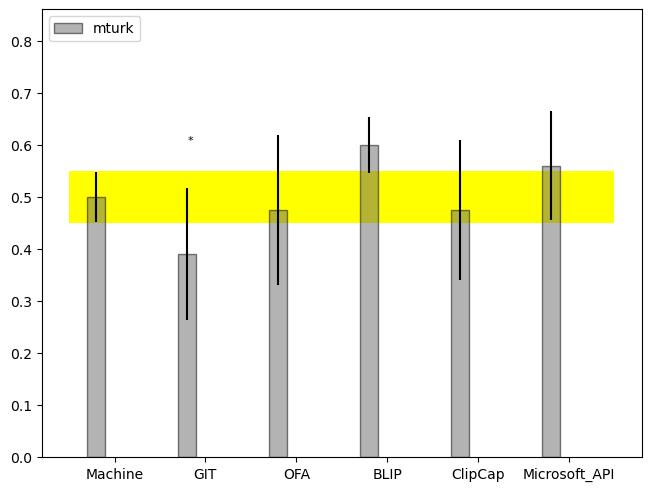

In [ ]:

#======================With or without gender questions=======
with open("./savedResults/compiled_test.json", 'r') as f:
    CompiledResults = json.load(f)

key = 'mturk' #choose from these choices: inlab, mturk
folderpath = './plots/Task1_' + key + '_' #for saving the plots

condition_chosen_list = ['mturk']
TextFilePath = './savedResults/Task1_' + key + '_' #not being used
plotpathname = './plots/Task1_' + key + '_demor_WwoGenderQuesBarPlotOverall_test' #for saving the plots
facebarcolor = ['dimgray','darkgrey','lightgrey']

plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)

#====================== quality controls (mturk versus inlab) =======
with open("./savedResults/compiled_test.json", 'r') as f:
    CompiledResults = json.load(f)

key = 'inlab_mturk' #choose from these choices: inlab, mturk
folderpath = './plots/Task1_' + key + '_' #for saving the plots

condition_chosen_list = ['mturk'] #'inlab',
TextFilePath = './savedResults/Task1_' + key + '_' #not being used
plotpathname = './plots/Task1_' + key + '_demor_mturk_inlab_BarPlotOveral_test' #for saving the plots
facebarcolor = ['dimgray','darkgrey','lightgrey']

plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)


### Comparing Mturk with AI experts

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
#from colour import Color
import seaborn as sn
import pandas as pd
from matplotlib import font_manager
from matplotlib.patches import Rectangle
 
import pingouin as pg
from scipy import stats
import random
import math
import statsmodels.api as sm 
from statsmodels.formula.api import ols

def outputIconForStats(pval):
    if pval <= 0.05:
        icon = '*'
    else:
        icon = ' '
    return icon

def setup_fonts():
    """Set up Arial fonts for plots"""
    arial_path = font_manager.findfont('Arial')
    arialbold_path = font_manager.findfont('Arial Bold')
    
    prop_arial = font_manager.FontProperties(fname=arial_path)
    prop_arialbold = font_manager.FontProperties(fname=arialbold_path)
    
    return prop_arial, prop_arialbold

def ConvertDictToDataFrame(datadict):
    #data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}    
    X = []
    Y = []
    for key in datadict.keys():
        for ele in datadict[key]:
            X.append(ele)
            Y.append(key)
        
    data = {'X': X, 'group': Y}
    df = pd.DataFrame.from_dict(data)
    return df

def ComputeStats_group1(d_cond):
    #compare against chance
    r_data = np.random.choice([0, 1], size=len(d_cond), p=[.5, .5])
    result = pg.ttest(d_cond, r_data, correction=True) 
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof

def ComputeStats_group2(data_d1, data_d2):
    result = pg.ttest(data_d1, data_d2, correction=True) 

    # reporting format in Turing project (p < 10−15, two-tailed t-test, t = 8.5, df = 478)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof
    
def ComputeStats_group3(data_dict):
    df = ConvertDictToDataFrame(data_dict)
    #print(df)
    mod = ols('X ~ group', data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    
    #A one-way ANOVA revealed that there [was or was not] a statistically significant difference in [dependent variable] 
    #between at least two groups (F(between groups df, within groups df) = [F-value], p = [p-value]).
    BetweenGP_df = aov_table.df.group
    WithinGP_df = aov_table.df.Residual
    Fval = aov_table.F.group
    pval = aov_table['PR(>F)'].group
    icon = outputIconForStats(pval)
    return icon, BetweenGP_df, WithinGP_df, Fval, pval

def displayStats_group12(pval, Tval, dof):    
    if pval < 0.05:
        print('There is difference between data1 and data2.')
        if pval > 0.01 and pval < 0.05:
            print("(p < 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.001 and pval <= 0.01:
            print("(p < 0.01, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.0001 and pval <= 0.001:
            print("(p < 0.001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        else:
            print("(p < 0.0001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
    else:
        print('There is NO difference between data1 and data2.')
        print("(p > 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")

        
def displayStats_group3(BetweenGP_df, WithinGP_df, Fval, pval):    
    print("F(" + str(BetweenGP_df) + ", " + str(WithinGP_df) + ") = " + str(Fval) +", p-val=" + str(pval))

    
def boostrap(data1, data2):
    import random
    import math
    store = []
    sample_mean = []
    if len(data1) < len(data2):
        SampleTimes = math.ceil(len(data1)/2)
        BootstrapTimes = len(data1)
    else:
        SampleTimes = math.ceil(len(data2)/2)
        BootstrapTimes = len(data2)
        
    print("bootstraptime",BootstrapTimes,"sampletime",SampleTimes)
    for i in range(BootstrapTimes):
        y1 = random.sample(data1, SampleTimes)
        #print(y1)
        y2 = random.sample(data2, SampleTimes)
        #print(y2)
        y_comb = y1+y2
        #print(y_comb)
        sample_mean.append(np.mean(np.array(y_comb), axis=0))
    
    stdval = np.std(np.array(sample_mean), axis=0)
    return stdval

def ConcatData(data1, data2):
    import random
    import math
    
    #print(data1)
    #print(data2)
    if len(data1) < len(data2):        
        BootstrapTimes = len(data1)
    else:        
        BootstrapTimes = len(data2)
    
    #print(BootstrapTimes)
    y1 = random.sample(data1, BootstrapTimes)
    #print(y1)
    y2 = random.sample(data2, BootstrapTimes)
    #print(y2)
    y_comb = y1+y2
    y_comb = np.array(y_comb)        
    return y_comb


def ComputeBarStdConfMat(contents):
    modelist = ['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    print(modelist)
    
    #initialize matrix of absolute counts   
    result = {'human':0, 'countH':0, 'machine':0, 'countM': 0, 'result_H':[], 'result_M':[]}
    for modelname in modelist:
        result[modelname] = 0
        result['count_'+modelname] = 0
        result['result_'+modelname]=[]
    #print(result)

    # Iterating over keys
    for trialid in contents:
        trialinfor = contents[trialid]['trialData']

        if trialinfor['groundtruth'] == 'human':
            result['countH'] = result['countH'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['human'] = result['human'] + 1
                result['result_H'].append(1)
            else:
                result['result_H'].append(0)
                
        else:
            result['countM'] = result['countM'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['machine'] = result['machine'] + 1
                result['result_M'].append(1)
            else:
                result['result_M'].append(0)
                
            modelname = trialinfor['machine_groundtruth']
            result['count_'+modelname] = result['count_'+modelname] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result[modelname] = result[modelname] + 1
                result['result_' + modelname].append(1)
            else:
                result['result_' + modelname].append(0)
                
    #print(result)

    #compute confusion matrix
    result_conf_mat = np.zeros((2+len(modelist),2),'float32')
    result_conf_mat[0][0] = result['human']/result['countH']
    result_conf_mat[0][1] = (result['countH'] - result['human'])/result['countH']  
    result_conf_mat[1][0] = (result['countM'] - result['machine'])/result['countM']
    result_conf_mat[1][1] = result['machine']/result['countM']

    for i, modelname in enumerate(modelist):
        result_conf_mat[i+2][0] = (result['count_'+modelname] - result[modelname])/result['count_'+modelname]
        result_conf_mat[i+2][1] = result[modelname]/result['count_'+modelname]

    result_conf_mat = np.around(result_conf_mat, decimals=2)
        
    stdmodelist = ['M', 'git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    modelist_stats = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    top1 = []
    top1_std = []
    resultFlist = {}
    data1tot = result['result_H']
    for i in range(1+len(modelist)):
        #print(i)
        top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
        # compute bootstrap accuracy
        # compute and save std for top1 accuracy
        top_std_AI = boostrap(result['result_H'], result['result_' + stdmodelist[i]])
        top1_std.append(top_std_AI)
        data2tot = result['result_' + stdmodelist[i]]
        #resultFlist[modelist_stats[i]] = np.concatenate((data1tot,data2tot))
        resultFlist[modelist_stats[i]] = ConcatData(data1tot,data2tot)
    #print(top1)
    
    return top1, top1_std, result_conf_mat, resultFlist


### plots for grouping demographic information
def plot_res_demographics_with_experts(condition_chosen_list, TextFilePath, plotname,facebarcolor, condition_results1, condition_results2):
    
    compiledAllConds = {}
    prop_arial, prop_arialbold = setup_fonts()
    
    modelist = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    Pdata = {} #data stored for computing statistics 
    #initialize PData
    for i in range(0,len(modelist)):
        Pdata[modelist[i]] = {}
    
    for condition_chosen in condition_chosen_list:

        if condition_chosen == 'mturk':
            condition_results = condition_results1
        elif condition_chosen == 'AIexperts':
            condition_results = condition_results2
        
        top1, top1std, result_conf_mat, resultFlist = ComputeBarStdConfMat(condition_results[condition_chosen])
        
        for i in range(0,len(modelist)):
            Pdata[modelist[i]][condition_chosen] = resultFlist[modelist[i]]
        
#         #compute barplot and errorbar of barplot
#         top1 = []
#         top1std = []

#         #compute confusion matrix
#         result_conf_mat = 

        compiledAllConds[condition_chosen] = top1
        compiledAllConds[condition_chosen +'_std'] = top1std
    
    ### we have the compiled resutls now; lets calculate stats
    chancePval = []
    groupPval = []
    print(modelist)
    print()
    for i in range(0,len(modelist)):
        for condition_chosen in condition_chosen_list:        
            #compute against chance 50%
            d_cond = Pdata[modelist[i]][condition_chosen]
            icon, pval, Tval, dof = ComputeStats_group1(d_cond)
            chancePval.append(icon)
        if len(Pdata[modelist[i]].keys()) == 2:
            data_d1 = Pdata[modelist[i]][condition_chosen_list[0]]
            data_d2 = Pdata[modelist[i]][condition_chosen_list[1]]
            icon, pval, Tval, dof =  ComputeStats_group2(data_d1, data_d2)
            groupPval.append(icon)
        elif len(Pdata[modelist[i]].keys()) >= 3: 
            icon, BetweenGP_df, WithinGP_df, Fval, pval = ComputeStats_group3(Pdata[modelist[i]])
            groupPval.append(icon)
        else:
            print("Oops!  This should NOT happen...")
    
    #data
    #x-axis
    years = list(range(1, len(modelist)))
    strtask = modelist
    #print(years)
    #print(strtask)

    # Figure Size
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(strtask))  # the label locations
    point_x = [] #for plotting stats * or n.s.
    
    width = 0.2  # the width of the bars
    if len(condition_chosen_list) == 2:
        multiplier = -0.5 #len(condition_chosen_list)
    else:
        multiplier = -1 #len(condition_chosen_list)
    #ngroups = len(condition_chosen_list)

    ax.add_patch(Rectangle((-0.5, 0.45), len(modelist), 0.1,facecolor='yellow'))
    #bar chart properties
    #ax.bar(strtask, top1, color ='black', width = 0.3)    

    for ind, condition_chosen in enumerate(condition_chosen_list):
    #for condition_chosen in condition_chosen_list:
    #for attribute, measurement in compiledAllConds.items():
        measurement = compiledAllConds[condition_chosen]
        measurement_std = compiledAllConds[condition_chosen + '_std']
        attribute = condition_chosen
        
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, yerr= measurement_std, width = width,alpha=0.5,
                       label=attribute, edgecolor='black', color=facebarcolor[ind], ecolor='black')#,
                       #align='center', alpha=0.5, ecolor='black', capsize=10,color ='black')
        #ax.bar_label(rects, padding=3)
        point_x.extend( (x+offset).tolist() )
        multiplier += 1
    
#     ax.bar(strtask, top1, yerr=top1std,
#        align='center', alpha=0.5, ecolor='black', capsize=10,
#        color ='black', width = 0.3)

    ########## ready for plotting stats
    #print(point_x)
    ###### getting statistics
    #chancePval, groupPval = getStats(condition_chosen_list, TextFilePath)
    point_x.sort(reverse=False)
    #print(point_x)
    for i, p in enumerate(point_x):        
        ax.text(p, .7, chancePval[i], fontsize=8, transform=ax.get_xaxis_transform())
    
    ax.set_xticks(x, strtask)
    ax.legend(loc='upper left', ncol=1, frameon=False, labelcolor=facebarcolor, 
              bbox_to_anchor=(0, 1.15), prop=prop_arial)
    
    # Apply font to x-tick labels
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(prop_arial)
        tick.set_fontsize(10)
        
    # Apply font to y-tick labels
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(prop_arial)
        tick.set_fontsize(10)

    ###### plot stats for each group of bars
    totalPx = len(point_x)
#     print(totalPx)
#     print(point_x)
    count = 0
    for s1 in range(0,totalPx, len(condition_chosen_list)):
        center_x = 0
        for s2 in range(0,len(condition_chosen_list)):
            center_x = center_x + point_x[s1+s2]
        center_x = center_x/len(condition_chosen_list)
        starting_x = point_x[s1]
        ending_x = point_x[s1+len(condition_chosen_list)-1]
        plt.plot(   np.array([starting_x, ending_x]),
                           np.arange(2)*0+0.82, 'k', label='chance (50%)')
        ax.text(center_x, .8, groupPval[count], fontsize=8, transform=ax.get_xaxis_transform())
        count = count + 1
    
    ###### ending: plot stats for each group of bars
    
    plt.ylabel('Top-1 Accuracy')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

    plt.ylim(0.25, 1)
    #plt.xlim(0.5, len(years)+0.5)

    #draw chance 0.5 
    chancex =np.arange(len(years)+2)-0.5
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    #plt.legend()

    fig.tight_layout()

    fig.set_figwidth(7)
    fig.set_figheight(5)

    #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(plotname + '.eps', format='eps', bbox_inches='tight')
    plt.savefig(plotname + '.png',  bbox_inches='tight')
    plt.show()
#     fig.savefig('../' + plotname + '.png', bbox_inches='tight')
#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.pdf', bbox_inches='tight')
    
#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.png', bbox_inches='tight')



In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
from matplotlib import font_manager
from matplotlib.patches import Rectangle
 
import pingouin as pg
from scipy import stats
from scipy.stats import ttest_1samp, ttest_ind, f_oneway
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import random
import math
import os

def outputIconForStats(pval):
    """Return appropriate statistical significance icon"""
    if pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    else:
        return ' '

def setup_fonts():
    """Set up Arial fonts for plots"""
    arial_path = font_manager.findfont('Arial')
    arialbold_path = font_manager.findfont('Arial Bold')
    
    prop_arial = font_manager.FontProperties(fname=arial_path)
    prop_arialbold = font_manager.FontProperties(fname=arialbold_path)
    
    return prop_arial, prop_arialbold

def ConvertDictToDataFrame(datadict):
    #data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}    
    X = []
    Y = []
    for key in datadict.keys():
        for ele in datadict[key]:
            X.append(ele)
            Y.append(key)
        
    data = {'X': X, 'group': Y}
    df = pd.DataFrame.from_dict(data)
    return df

def ComputeStats_group1(data, chance_level=0.5):
    """Compute one-sample t-test against chance level"""
    t_stat, p_val = ttest_1samp(data, chance_level)
    dof = len(data) - 1
    return ('', p_val, t_stat, dof)

def ComputeStats_group2(data_d1, data_d2):
    result = pg.ttest(data_d1, data_d2, correction=True) 

    # reporting format in Turing project (p < 10−15, two-tailed t-test, t = 8.5, df = 478)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof
    
def ComputeStats_group3(data_dict):
    df = ConvertDictToDataFrame(data_dict)
    #print(df)
    mod = ols('X ~ group', data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    
    #A one-way ANOVA revealed that there [was or was not] a statistically significant difference in [dependent variable] 
    #between at least two groups (F(between groups df, within groups df) = [F-value], p = [p-value]).
    BetweenGP_df = aov_table.df.group
    WithinGP_df = aov_table.df.Residual
    Fval = aov_table.F.group
    pval = aov_table['PR(>F)'].group
    icon = outputIconForStats(pval)
    return icon, BetweenGP_df, WithinGP_df, Fval, pval

def displayStats_group12(pval, Tval, dof):    
    if pval < 0.05:
        print('There is difference between data1 and data2.')
        if pval > 0.01 and pval < 0.05:
            print("(p < 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.001 and pval <= 0.01:
            print("(p < 0.01, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.0001 and pval <= 0.001:
            print("(p < 0.001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        else:
            print("(p < 0.0001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
    else:
        print('There is NO difference between data1 and data2.')
        print("(p > 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")

def displayStats_group3(BetweenGP_df, WithinGP_df, Fval, pval):    
    print("F(" + str(BetweenGP_df) + ", " + str(WithinGP_df) + ") = " + str(Fval) +", p-val=" + str(pval))

# Enhanced bootstrap functions from first code
def bootstrap_sample_statistic(data, statistic=np.mean, n_bootstrap=1000, random_state=None):
    """
    Generate bootstrap distribution for a statistic on a single sample.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n = len(data)
    bootstrap_stats = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        resample = np.random.choice(data, size=n, replace=True)
        bootstrap_stats[i] = statistic(resample)
    
    confidence_interval = np.percentile(bootstrap_stats, [2.5, 97.5])
    bootstrap_se = np.std(bootstrap_stats, ddof=1)
    
    return {
        'bootstrap_stats': bootstrap_stats,
        'confidence_interval': confidence_interval,
        'bootstrap_se': bootstrap_se
    }

def bootstrap_against_chance(data, chance_level=0.5, n_bootstrap=1000, random_state=None):
    """
    Test if data is significantly different from chance using bootstrap.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    observed_mean = np.mean(data)
    observed_diff = observed_mean - chance_level
    
    # Bootstrap resampling
    bootstrap_result = bootstrap_sample_statistic(data, np.mean, n_bootstrap, random_state)
    bootstrap_means = bootstrap_result['bootstrap_stats']
    
    # Calculate p-value (two-tailed)
    p_value = np.mean(np.abs(bootstrap_means - chance_level) >= np.abs(observed_diff))
    
    return p_value, bootstrap_result

def bootstrap_ttest(data1, data2, n_bootstrap=1000, random_state=None):
    """
    Performs a bootstrap t-test for comparing two independent samples.
    Uses the minimum sample size for both groups and calculates p-value 
    by determining if zero is within the distribution of differences.
    """
    # Set random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
    
    # Calculate observed difference in means
    observed_diff = np.mean(data1) - np.mean(data2)
    
    # Store bootstrap differences
    bootstrap_diffs = np.zeros(n_bootstrap)
    
    # Only sample as much as the minimal group
    min_size = min(len(data1), len(data2))
    
    # Bootstrap resampling
    for i in range(n_bootstrap):
        # Resample with replacement from each dataset
        resample1 = np.random.choice(data1, size=min_size, replace=True)
        resample2 = np.random.choice(data2, size=min_size, replace=True)
        
        # Calculate and store the mean difference for this bootstrap sample
        bootstrap_diffs[i] = np.mean(resample1) - np.mean(resample2)
    
    # Calculate p-value based on where 0 falls in the bootstrap distribution
    # Sort the bootstrap differences
    sorted_diffs = np.sort(bootstrap_diffs)
    
    # Find where 0 would be in the sorted distribution
    if 0 < sorted_diffs[0]:  # 0 is below all values
        p_value = 1/n_bootstrap  # Smallest possible p-value
    elif 0 > sorted_diffs[-1]:  # 0 is above all values
        p_value = 1/n_bootstrap  # Smallest possible p-value
    else:
        # Find percentile of 0 in the distribution
        zero_percentile = np.sum(sorted_diffs < 0) / n_bootstrap
        # Two-tailed p-value: 2 * min(percentile, 1-percentile)
        p_value = 2 * min(zero_percentile, 1 - zero_percentile)
    
    # Calculate 95% confidence interval
    confidence_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])
    
    # Calculate bootstrap standard error
    bootstrap_se = np.std(bootstrap_diffs, ddof=1)
    
    return {
        'mean_diff': observed_diff,
        'p_value': p_value,
        'confidence_interval': confidence_interval,
        'bootstrap_diffs': bootstrap_diffs,
        'bootstrap_se': bootstrap_se
    }

def ConcatData(data1, data2):
    """
    Concatenate data samples of possibly different sizes, 
    downsampling the larger one to match the smaller one.
    """
    if len(data1) < len(data2):        
        sample_size = len(data1)
    else:        
        sample_size = len(data2)
    
    y1 = random.sample(list(data1), sample_size)
    y2 = random.sample(list(data2), sample_size)
    y_comb = y1 + y2
    y_comb = np.array(y_comb)        
    return y_comb

def ComputeBarStdConfMat(contents, n_bootstrap=1000, random_state=42):
    """Compute bar chart data with bootstrap standard errors"""
    modelist = ['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    print(modelist)
    
    #initialize matrix of absolute counts   
    result = {'human':0, 'countH':0, 'machine':0, 'countM': 0, 'result_H':[], 'result_M':[]}
    for modelname in modelist:
        result[modelname] = 0
        result['count_'+modelname] = 0
        result['result_'+modelname]=[]
    
    # Iterating over keys
    for trialid in contents:
        trialinfor = contents[trialid]['trialData']

        if trialinfor['groundtruth'] == 'human':
            result['countH'] = result['countH'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['human'] = result['human'] + 1
                result['result_H'].append(1)
            else:
                result['result_H'].append(0)
                
        else:
            result['countM'] = result['countM'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['machine'] = result['machine'] + 1
                result['result_M'].append(1)
            else:
                result['result_M'].append(0)
                
            modelname = trialinfor['machine_groundtruth']
            result['count_'+modelname] = result['count_'+modelname] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result[modelname] = result[modelname] + 1
                result['result_' + modelname].append(1)
            else:
                result['result_' + modelname].append(0)

    #compute confusion matrix
    result_conf_mat = np.zeros((2+len(modelist),2),'float32')
    result_conf_mat[0][0] = result['human']/result['countH']
    result_conf_mat[0][1] = (result['countH'] - result['human'])/result['countH']  
    result_conf_mat[1][0] = (result['countM'] - result['machine'])/result['countM']
    result_conf_mat[1][1] = result['machine']/result['countM']

    for i, modelname in enumerate(modelist):
        result_conf_mat[i+2][0] = (result['count_'+modelname] - result[modelname])/result['count_'+modelname]
        result_conf_mat[i+2][1] = result[modelname]/result['count_'+modelname]

    result_conf_mat = np.around(result_conf_mat, decimals=2)
        
    stdmodelist = ['M', 'git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    modelist_stats = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    top1 = []
    top1_std = []
    resultFlist = {}
    data1tot = result['result_H']
    
    for i in range(1+len(modelist)):
        # Calculate top-1 accuracy
        top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
        data2tot = result['result_' + stdmodelist[i]]
        
        # Use enhanced bootstrap for standard error calculation
        if len(data1tot) > 0 and len(data2tot) > 0:
            # Combine the data for human and machine classification
            combined_data = np.concatenate([data1tot, data2tot])
            
            # Use bootstrap to get standard error
            bootstrap_result = bootstrap_sample_statistic(
                combined_data, np.mean, n_bootstrap, random_state)
            
            # Store the bootstrap standard error
            top1_std.append(bootstrap_result['bootstrap_se'])
            
            # Store the combined data for later statistical analysis
            resultFlist[modelist_stats[i]] = combined_data
        else:
            # Handle empty data case
            top1_std.append(0)
            resultFlist[modelist_stats[i]] = np.array([])
    
    return top1, top1_std, result_conf_mat, resultFlist

def plot_res_demographics_with_bootstrap(condition_chosen_list, TextFilePath, plotname, facebarcolor, 
                                        condition_results1, condition_results2, 
                                        bonferroni=1, n_bootstrap=1000, random_state=42):
    """
    Plot demographic results using bootstrap for statistical analysis.
    
    Parameters:
    -----------
    condition_chosen_list : list
        List of condition names to process
    TextFilePath : str
        Base path for saving output files
    plotname : str
        Base name for output plot files
    facebarcolor : list
        List of colors for different condition bars
    condition_results1 : dict
        Results for the first condition (mturk)
    condition_results2 : dict
        Results for the second condition (AIexperts)
    bonferroni : int
        Whether to apply Bonferroni correction (1) or not (0)
    n_bootstrap : int
        Number of bootstrap samples to generate
    random_state : int
        Random seed for reproducibility
    """
    
    # Set up fonts
    prop_arial, prop_arialbold = setup_fonts()
    
    compiledAllConds = {}
    modelist = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    
    # Storage for raw data
    Pdata = {}  
    for i in range(0, len(modelist)):
        Pdata[modelist[i]] = {}
    
    # Process each condition
    for condition_chosen in condition_chosen_list:
        print('Loading results for condition', condition_chosen)
        
        # Select appropriate results data
        if condition_chosen == 'mturk':
            condition_results = condition_results1
        elif condition_chosen == 'AIexperts':
            condition_results = condition_results2
        else:
            print(f"Unknown condition: {condition_chosen}")
            continue
            
        # Compute bar statistics with enhanced bootstrap
        top1, top1std, result_conf_mat, resultFlist = ComputeBarStdConfMat(
            condition_results[condition_chosen], n_bootstrap, random_state)
        
        # Store data for each model type
        for i in range(0, len(modelist)):
            Pdata[modelist[i]][condition_chosen] = resultFlist[modelist[i]]
        
        # Store aggregated results
        compiledAllConds[condition_chosen] = top1
        compiledAllConds[condition_chosen + '_std'] = top1std
    
    # ----- BOOTSTRAP STATISTICS SECTION ------
    
    # Storage for bootstrap results
    bootstrap_results = {}
    chanceRealPval = []
    groupRealPval = []
    
    # Compute statistics for each model
    print("Computing statistics for each model...")
    for i in range(0, len(modelist)):
        model_name = modelist[i]
        bootstrap_results[model_name] = {}
        
        for condition_chosen in condition_chosen_list:
            # Get the data
            data = Pdata[model_name][condition_chosen]
            
            if len(data) > 0:
                # Perform t-test against chance level
                _, p_val, t_stat, dof = ComputeStats_group1(data, chance_level=0.5)
                
                chanceRealPval.append(p_val)
                print(f"Model: {model_name}, Condition: {condition_chosen}")
                print(f"  t({dof}) = {t_stat:.3f}, p = {p_val:.4f}")
                
                # Store t-test result
                t_test_result = {
                    't_stat': t_stat,
                    'p_value': p_val,
                    'dof': dof,
                    'stderr': np.std(data, ddof=1) / np.sqrt(len(data))
                }
                
                bootstrap_results[model_name][condition_chosen] = t_test_result
            else:
                print(f"No data for Model: {model_name}, Condition: {condition_chosen}")
                chanceRealPval.append(np.nan)
                
                # Store empty result
                bootstrap_results[model_name][condition_chosen] = {
                    't_stat': np.nan,
                    'p_value': np.nan,
                    'dof': 0,
                    'stderr': 0
                }
        
        # Compare between conditions if multiple conditions
        if len(condition_chosen_list) == 2:
            data_d1 = Pdata[model_name][condition_chosen_list[0]]
            data_d2 = Pdata[model_name][condition_chosen_list[1]]
            
            if len(data_d1) > 0 and len(data_d2) > 0:
                # Print sample sizes
                print(f"Model: {model_name}, Sample sizes: {len(data_d1)} vs {len(data_d2)}")
                
                # Bootstrap comparison between conditions
                boot_result = bootstrap_ttest(
                    data_d1, data_d2, n_bootstrap=n_bootstrap, random_state=random_state)
                
                pval = boot_result['p_value']
                bootstrap_results[model_name]['condition_comparison'] = boot_result
                
                groupRealPval.append(pval)
                
                # Print comparison results
                print(f"  Bootstrap p-value: {pval:.4f}")
                print(f"  Mean difference: {boot_result['mean_diff']:.4f}")
                print(f"  95% CI: [{boot_result['confidence_interval'][0]:.4f}, {boot_result['confidence_interval'][1]:.4f}]")
            else:
                print(f"Insufficient data for comparison: Model {model_name}")
                groupRealPval.append(np.nan)
                bootstrap_results[model_name]['condition_comparison'] = {
                    'p_value': np.nan,
                    'mean_diff': np.nan,
                    'confidence_interval': [np.nan, np.nan],
                    'bootstrap_se': np.nan
                }
    
    # Bonferroni correction
    compiled_pvals = np.array(chanceRealPval + groupRealPval)
    
    # Filter out NaN values before correction
    valid_indices = ~np.isnan(compiled_pvals)
    valid_pvals = compiled_pvals[valid_indices]
    
    if bonferroni == 1 and len(valid_pvals) > 0:
        # Apply Bonferroni correction
        try:
            pvalFlags, corrected_valid_pvals, _, alphacBonf = multipletests(
                valid_pvals, alpha=0.05, method='bonferroni',
                is_sorted=False, returnsorted=False
            )
        except Exception as e:
            print(f"Error in multipletests: {e}")
            # Fallback to simple correction
            corrected_valid_pvals = valid_pvals * len(valid_pvals)
            corrected_valid_pvals = np.minimum(corrected_valid_pvals, 1.0)  # Cap at 1.0
            alphacBonf = 0.05 / len(valid_pvals)
            
        # Put corrected values back in the original array structure
        correctedPvals = np.full(compiled_pvals.shape, np.nan)
        correctedPvals[valid_indices] = corrected_valid_pvals
            
        print('Bonferroni correction applied')
        print('Corrected Alpha:', alphacBonf)
    else:
        # No correction - use original p-values
        correctedPvals = compiled_pvals
        print('No correction applied to p-values - using raw p-values')
    
    # Convert to list
    correctedPvals = list(correctedPvals)
    
    # Convert p-values to significance icons
    chancePval = []
    groupPval = []

    if len(correctedPvals) >= len(chanceRealPval):
        # Process chance comparison p-values
        for i in range(len(chanceRealPval)):
            pval = correctedPvals[i]
            if np.isnan(pval):
                chancePval.append(' ')
            else:
                chancePval.append(outputIconForStats(pval))
        
        # Process group comparison p-values
        if len(correctedPvals) >= len(chanceRealPval) + len(groupRealPval):
            for i in range(len(groupRealPval)):
                pval = correctedPvals[i + len(chanceRealPval)]
                if np.isnan(pval):
                    groupPval.append(' ')
                else:
                    groupPval.append(outputIconForStats(pval))
        else:
            groupPval = [' '] * len(groupRealPval)
    else:
        # Handle case where correctedPvals doesn't have enough values
        print("Warning: Not enough corrected p-values available")
        chancePval = [' '] * len(chanceRealPval)
        groupPval = [' '] * len(groupRealPval)

    print("Chance p-values:", chancePval)
    print("Group p-values:", groupPval)

    # ----- PLOTTING SECTION ------
    
    # Create axis arrays
    years = list(range(1, len(modelist)))
    strtask = modelist
    
    # Create figure
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(strtask))  # the label locations
    point_x = []  # for plotting stats * or n.s.
    
    width = 0.2  # the width of the bars
    if len(condition_chosen_list) == 2:
        multiplier = -0.5
    else:
        multiplier = -1
    
    # Add yellow rectangle for chance level
    #ax.add_patch(Rectangle((-0.5, 0.45), len(modelist), 0.1, facecolor='yellow', alpha=0.3))
    
    # Create bar plots for each condition
    for ind, condition_chosen in enumerate(condition_chosen_list):
        measurement = compiledAllConds[condition_chosen]
        stderr_values = []
        
        # Get the stderr from bootstrap results for this condition
        for i, model_name in enumerate(modelist):
            t_test_result = bootstrap_results[model_name][condition_chosen]
            stderr_values.append(t_test_result['stderr'])
        
        # Set the attribute name (label)
        if condition_chosen == "mturk":
            attribute = 'MTurk'
        else: 
            attribute = 'AI experts'
        
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, yerr=stderr_values, width=width,
                     label=attribute, edgecolor='black', color=facebarcolor[ind], ecolor='black')
        
        point_x.extend((x+offset).tolist())
        multiplier += 1
    
    # Apply font styles to all text elements
    plt.rcParams['font.family'] = 'Arial'
    
    # Add statistical significance annotations
    point_x.sort(reverse=False)
    for i, p in enumerate(point_x):
        if i < len(chancePval):
            ax.text(p, 0.7, chancePval[i], fontsize=8, color='blue', 
                    horizontalalignment='center', transform=ax.get_xaxis_transform(),
                    fontproperties=prop_arial)
    
    ax.set_xticks(x, strtask)
    
    # Apply font to x-tick labels
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(prop_arial)
        tick.set_fontsize(10)
        
    # Apply font to y-tick labels
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(prop_arial)
        tick.set_fontsize(10)
    
    # Configure legend with custom font
    ax.legend(loc='upper left', ncol=1, frameon=False, labelcolor=facebarcolor, 
              bbox_to_anchor=(0, 1.15), prop=prop_arial)
    
    # Set title with custom font
    plt.title('Model Comparison', fontproperties=prop_arialbold, fontsize=14)
    
    # Add horizontal lines and group comparison p-values
    totalPx = len(point_x)
    count = 0
    for s1 in range(0, totalPx, len(condition_chosen_list)):
        if s1 + len(condition_chosen_list) <= len(point_x):
            center_x = 0
            for s2 in range(0, len(condition_chosen_list)):
                center_x = center_x + point_x[s1+s2]
            center_x = center_x / len(condition_chosen_list)
            starting_x = point_x[s1]
            ending_x = point_x[s1+len(condition_chosen_list)-1]
            
            plt.plot(np.array([starting_x, ending_x]),
                     np.arange(2)*0+0.82, 'k')
            
            if count < len(groupPval):
                ax.text(center_x, 0.82, groupPval[count], fontsize=8, 
                        horizontalalignment='center', transform=ax.get_xaxis_transform(),
                        fontproperties=prop_arial)
            count += 1
    
    # Finalize plot
    plt.ylabel('Imitation detectability')
    plt.xticks(rotation=90)  # Rotates X-Axis Ticks by 90-degrees
    plt.ylim(0.25, 1)
    
    # Draw chance 0.5
    chancex = np.arange(len(years)+2)-0.5
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    
    fig.tight_layout()
    fig.set_figwidth(7)
    fig.set_figheight(5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Save plots
    plt.savefig(plotname + '.eps', format='eps', bbox_inches='tight')
    plt.savefig(plotname + '.png', bbox_inches='tight')
    plt.show()

# Example usage:
# condition_chosen_list = ['mturk', 'AIexperts']
# TextFilePath = './results/'
# plotname = 'comparison_plot'
# facebarcolor = ['blue', 'red']
# plot_res_demographics_with_bootstrap(condition_chosen_list, TextFilePath, plotname, facebarcolor, 
#                                     condition_results1, condition_results2, bonferroni=1)

In [6]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
from matplotlib import font_manager
from matplotlib.patches import Rectangle
 
import pingouin as pg
from scipy import stats
from scipy.stats import ttest_1samp, ttest_ind, f_oneway
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import random
import math
import os

def outputIconForStats(pval):
    """Return appropriate statistical significance icon"""
    if pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    else:
        return ' '

def setup_fonts():
    """Set up Arial fonts for plots"""
    arial_path = font_manager.findfont('Arial')
    arialbold_path = font_manager.findfont('Arial Bold')
    
    prop_arial = font_manager.FontProperties(fname=arial_path)
    prop_arialbold = font_manager.FontProperties(fname=arialbold_path)
    
    return prop_arial, prop_arialbold

def ConvertDictToDataFrame(datadict):
    #data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}    
    X = []
    Y = []
    for key in datadict.keys():
        for ele in datadict[key]:
            X.append(ele)
            Y.append(key)
        
    data = {'X': X, 'group': Y}
    df = pd.DataFrame.from_dict(data)
    return df

def ComputeStats_group1(data, chance_level=0.5):
    """Compute one-sample t-test against chance level"""
    t_stat, p_val = ttest_1samp(data, chance_level)
    dof = len(data) - 1
    return ('', p_val, t_stat, dof)

def ComputeStats_group2(data_d1, data_d2):
    result = pg.ttest(data_d1, data_d2, correction=True) 

    # reporting format in Turing project (p < 10−15, two-tailed t-test, t = 8.5, df = 478)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof
    
def ComputeStats_group3(data_dict):
    df = ConvertDictToDataFrame(data_dict)
    #print(df)
    mod = ols('X ~ group', data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    
    #A one-way ANOVA revealed that there [was or was not] a statistically significant difference in [dependent variable] 
    #between at least two groups (F(between groups df, within groups df) = [F-value], p = [p-value]).
    BetweenGP_df = aov_table.df.group
    WithinGP_df = aov_table.df.Residual
    Fval = aov_table.F.group
    pval = aov_table['PR(>F)'].group
    icon = outputIconForStats(pval)
    return icon, BetweenGP_df, WithinGP_df, Fval, pval

def displayStats_group12(pval, Tval, dof):    
    if pval < 0.05:
        print('There is difference between data1 and data2.')
        if pval > 0.01 and pval < 0.05:
            print("(p < 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.001 and pval <= 0.01:
            print("(p < 0.01, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.0001 and pval <= 0.001:
            print("(p < 0.001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        else:
            print("(p < 0.0001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
    else:
        print('There is NO difference between data1 and data2.')
        print("(p > 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")

def displayStats_group3(BetweenGP_df, WithinGP_df, Fval, pval):    
    print("F(" + str(BetweenGP_df) + ", " + str(WithinGP_df) + ") = " + str(Fval) +", p-val=" + str(pval))

# Enhanced bootstrap functions from first code
def bootstrap_sample_statistic(data, statistic=np.mean, n_bootstrap=1000, random_state=None):
    """
    Generate bootstrap distribution for a statistic on a single sample.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n = len(data)
    bootstrap_stats = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        resample = np.random.choice(data, size=n, replace=True)
        bootstrap_stats[i] = statistic(resample)
    
    confidence_interval = np.percentile(bootstrap_stats, [2.5, 97.5])
    bootstrap_se = np.std(bootstrap_stats, ddof=1)
    
    return {
        'bootstrap_stats': bootstrap_stats,
        'confidence_interval': confidence_interval,
        'bootstrap_se': bootstrap_se
    }

def bootstrap_against_chance(data, chance_level=0.5, n_bootstrap=1000, random_state=None):
    """
    Test if data is significantly different from chance using bootstrap.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    observed_mean = np.mean(data)
    observed_diff = observed_mean - chance_level
    
    # Bootstrap resampling
    bootstrap_result = bootstrap_sample_statistic(data, np.mean, n_bootstrap, random_state)
    bootstrap_means = bootstrap_result['bootstrap_stats']
    
    # Calculate p-value (two-tailed)
    p_value = np.mean(np.abs(bootstrap_means - chance_level) >= np.abs(observed_diff))
    
    return p_value, bootstrap_result

def bootstrap_ttest(data1, data2, n_bootstrap=1000, random_state=None):
    """
    Performs a bootstrap t-test for comparing two independent samples.
    Uses the minimum sample size for both groups and calculates p-value 
    by determining if zero is within the distribution of differences.
    """
    # Set random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
    
    # Calculate observed difference in means
    observed_diff = np.mean(data1) - np.mean(data2)
    
    # Store bootstrap differences
    bootstrap_diffs = np.zeros(n_bootstrap)
    
    # Only sample as much as the minimal group
    min_size = min(len(data1), len(data2))
    
    # Bootstrap resampling
    for i in range(n_bootstrap):
        # Resample with replacement from each dataset
        resample1 = np.random.choice(data1, size=min_size, replace=True)
        resample2 = np.random.choice(data2, size=min_size, replace=True)
        
        # Calculate and store the mean difference for this bootstrap sample
        bootstrap_diffs[i] = np.mean(resample1) - np.mean(resample2)
    
    # Calculate p-value based on where 0 falls in the bootstrap distribution
    # Sort the bootstrap differences
    sorted_diffs = np.sort(bootstrap_diffs)
    
    # Find where 0 would be in the sorted distribution
    if 0 < sorted_diffs[0]:  # 0 is below all values
        p_value = 1/n_bootstrap  # Smallest possible p-value
    elif 0 > sorted_diffs[-1]:  # 0 is above all values
        p_value = 1/n_bootstrap  # Smallest possible p-value
    else:
        # Find percentile of 0 in the distribution
        zero_percentile = np.sum(sorted_diffs < 0) / n_bootstrap
        # Two-tailed p-value: 2 * min(percentile, 1-percentile)
        p_value = 2 * min(zero_percentile, 1 - zero_percentile)
    
    # Calculate 95% confidence interval
    confidence_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])
    
    # Calculate bootstrap standard error
    bootstrap_se = np.std(bootstrap_diffs, ddof=1)
    
    return {
        'mean_diff': observed_diff,
        'p_value': p_value,
        'confidence_interval': confidence_interval,
        'bootstrap_diffs': bootstrap_diffs,
        'bootstrap_se': bootstrap_se
    }

def ConcatData(data1, data2):
    """
    Concatenate data samples of possibly different sizes, 
    downsampling the larger one to match the smaller one.
    """
    if len(data1) < len(data2):        
        sample_size = len(data1)
    else:        
        sample_size = len(data2)
    
    y1 = random.sample(list(data1), sample_size)
    y2 = random.sample(list(data2), sample_size)
    y_comb = y1 + y2
    y_comb = np.array(y_comb)        
    return y_comb

def ComputeBarStdConfMat(contents, n_bootstrap=1000, random_state=42):
    """Compute bar chart data with bootstrap standard errors"""
    modelist = ['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    print(modelist)
    
    #initialize matrix of absolute counts   
    result = {'human':0, 'countH':0, 'machine':0, 'countM': 0, 'result_H':[], 'result_M':[]}
    for modelname in modelist:
        result[modelname] = 0
        result['count_'+modelname] = 0
        result['result_'+modelname]=[]
    
    # Iterating over keys
    for trialid in contents:
        trialinfor = contents[trialid]['trialData']

        if trialinfor['groundtruth'] == 'human':
            result['countH'] = result['countH'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['human'] = result['human'] + 1
                result['result_H'].append(1)
            else:
                result['result_H'].append(0)
                
        else:
            result['countM'] = result['countM'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['machine'] = result['machine'] + 1
                result['result_M'].append(1)
            else:
                result['result_M'].append(0)
                
            modelname = trialinfor['machine_groundtruth']
            result['count_'+modelname] = result['count_'+modelname] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result[modelname] = result[modelname] + 1
                result['result_' + modelname].append(1)
            else:
                result['result_' + modelname].append(0)

    #compute confusion matrix
    result_conf_mat = np.zeros((2+len(modelist),2),'float32')
    result_conf_mat[0][0] = result['human']/result['countH']
    result_conf_mat[0][1] = (result['countH'] - result['human'])/result['countH']  
    result_conf_mat[1][0] = (result['countM'] - result['machine'])/result['countM']
    result_conf_mat[1][1] = result['machine']/result['countM']

    for i, modelname in enumerate(modelist):
        result_conf_mat[i+2][0] = (result['count_'+modelname] - result[modelname])/result['count_'+modelname]
        result_conf_mat[i+2][1] = result[modelname]/result['count_'+modelname]

    result_conf_mat = np.around(result_conf_mat, decimals=2)
        
    stdmodelist = ['M', 'git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    modelist_stats = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    top1 = []
    top1_std = []
    resultFlist = {}
    data1tot = result['result_H']
    
    for i in range(1+len(modelist)):
        # Calculate top-1 accuracy
        top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
        data2tot = result['result_' + stdmodelist[i]]
        
        # Use enhanced bootstrap for standard error calculation
        if len(data1tot) > 0 and len(data2tot) > 0:
            # Combine the data for human and machine classification
            combined_data = np.concatenate([data1tot, data2tot])
            
            # Use bootstrap to get standard error
            bootstrap_result = bootstrap_sample_statistic(
                combined_data, np.mean, n_bootstrap, random_state)
            
            # Store the bootstrap standard error
            top1_std.append(bootstrap_result['bootstrap_se'])
            
            # Store the combined data for later statistical analysis
            resultFlist[modelist_stats[i]] = combined_data
        else:
            # Handle empty data case
            top1_std.append(0)
            resultFlist[modelist_stats[i]] = np.array([])
    
    return top1, top1_std, result_conf_mat, resultFlist

def plot_res_demographics_with_bootstrap(condition_chosen_list, TextFilePath, plotname, facebarcolor, 
                                        condition_results1, condition_results2, 
                                        bonferroni=1, n_bootstrap=1000, random_state=42):
    """
    Plot demographic results using bootstrap for statistical analysis.
    
    Parameters:
    -----------
    condition_chosen_list : list
        List of condition names to process
    TextFilePath : str
        Base path for saving output files
    plotname : str
        Base name for output plot files
    facebarcolor : list
        List of colors for different condition bars
    condition_results1 : dict
        Results for the first condition (mturk)
    condition_results2 : dict
        Results for the second condition (AIexperts)
    bonferroni : int
        Whether to apply Bonferroni correction (1) or not (0)
    n_bootstrap : int
        Number of bootstrap samples to generate
    random_state : int
        Random seed for reproducibility
    """
    
    # Set up fonts
    prop_arial, prop_arialbold = setup_fonts()
    
    compiledAllConds = {}
    modelist = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    
    # Storage for raw data
    Pdata = {}  
    for i in range(0, len(modelist)):
        Pdata[modelist[i]] = {}
    
    # Process each condition
    for condition_chosen in condition_chosen_list:
        print('Loading results for condition', condition_chosen)
        
        # Select appropriate results data
        if condition_chosen == 'mturk':
            condition_results = condition_results1
        elif condition_chosen == 'AIexperts':
            condition_results = condition_results2
        else:
            print(f"Unknown condition: {condition_chosen}")
            continue
            
        # Compute bar statistics with enhanced bootstrap
        top1, top1std, result_conf_mat, resultFlist = ComputeBarStdConfMat(
            condition_results[condition_chosen], n_bootstrap, random_state)
        
        # Store data for each model type
        for i in range(0, len(modelist)):
            Pdata[modelist[i]][condition_chosen] = resultFlist[modelist[i]]
        
        # Store aggregated results
        compiledAllConds[condition_chosen] = top1
        compiledAllConds[condition_chosen + '_std'] = top1std
    
    # ----- BOOTSTRAP STATISTICS SECTION ------
    
    # Storage for bootstrap results
    bootstrap_results = {}
    chanceRealPval = []
    groupRealPval = []
    
    # Compute statistics for each model
    print("Computing statistics for each model...")
    for i in range(0, len(modelist)):
        model_name = modelist[i]
        bootstrap_results[model_name] = {}
        
        for condition_chosen in condition_chosen_list:
            # Get the data
            data = Pdata[model_name][condition_chosen]
            
            if len(data) > 0:
                # Perform t-test against chance level
                _, p_val, t_stat, dof = ComputeStats_group1(data, chance_level=0.5)
                
                chanceRealPval.append(p_val)
                print(f"Model: {model_name}, Condition: {condition_chosen}")
                print(f"  t({dof}) = {t_stat:.3f}, p = {p_val:.4f}")
                
                # Store t-test result
                t_test_result = {
                    't_stat': t_stat,
                    'p_value': p_val,
                    'dof': dof,
                    'stderr': np.std(data, ddof=1) / np.sqrt(len(data))
                }
                
                bootstrap_results[model_name][condition_chosen] = t_test_result
            else:
                print(f"No data for Model: {model_name}, Condition: {condition_chosen}")
                chanceRealPval.append(np.nan)
                
                # Store empty result
                bootstrap_results[model_name][condition_chosen] = {
                    't_stat': np.nan,
                    'p_value': np.nan,
                    'dof': 0,
                    'stderr': 0
                }
        
        # Compare between conditions if multiple conditions
        if len(condition_chosen_list) == 2:
            data_d1 = Pdata[model_name][condition_chosen_list[0]]
            data_d2 = Pdata[model_name][condition_chosen_list[1]]
            
            if len(data_d1) > 0 and len(data_d2) > 0:
                # Print sample sizes
                print(f"Model: {model_name}, Sample sizes: {len(data_d1)} vs {len(data_d2)}")
                
                # Bootstrap comparison between conditions
                boot_result = bootstrap_ttest(
                    data_d1, data_d2, n_bootstrap=n_bootstrap, random_state=random_state)
                
                pval = boot_result['p_value']
                bootstrap_results[model_name]['condition_comparison'] = boot_result
                
                groupRealPval.append(pval)
                
                # Print comparison results
                print(f"  Bootstrap p-value: {pval:.4f}")
                print(f"  Mean difference: {boot_result['mean_diff']:.4f}")
                print(f"  95% CI: [{boot_result['confidence_interval'][0]:.4f}, {boot_result['confidence_interval'][1]:.4f}]")
            else:
                print(f"Insufficient data for comparison: Model {model_name}")
                groupRealPval.append(np.nan)
                bootstrap_results[model_name]['condition_comparison'] = {
                    'p_value': np.nan,
                    'mean_diff': np.nan,
                    'confidence_interval': [np.nan, np.nan],
                    'bootstrap_se': np.nan
                }
    
    # Bonferroni correction
    compiled_pvals = np.array(chanceRealPval + groupRealPval)
    
    # Filter out NaN values before correction
    valid_indices = ~np.isnan(compiled_pvals)
    valid_pvals = compiled_pvals[valid_indices]
    
    if bonferroni == 1 and len(valid_pvals) > 0:
        # Apply Bonferroni correction
        try:
            pvalFlags, corrected_valid_pvals, _, alphacBonf = multipletests(
                valid_pvals, alpha=0.05, method='bonferroni',
                is_sorted=False, returnsorted=False
            )
        except Exception as e:
            print(f"Error in multipletests: {e}")
            # Fallback to simple correction
            corrected_valid_pvals = valid_pvals * len(valid_pvals)
            corrected_valid_pvals = np.minimum(corrected_valid_pvals, 1.0)  # Cap at 1.0
            alphacBonf = 0.05 / len(valid_pvals)
            
        # Put corrected values back in the original array structure
        correctedPvals = np.full(compiled_pvals.shape, np.nan)
        correctedPvals[valid_indices] = corrected_valid_pvals
            
        print('Bonferroni correction applied')
        print('Corrected Alpha:', alphacBonf)
    else:
        # No correction - use original p-values
        correctedPvals = compiled_pvals
        print('No correction applied to p-values - using raw p-values')
    
    # Convert to list
    correctedPvals = list(correctedPvals)
    
    # Convert p-values to significance icons
    chancePval = []
    groupPval = []

    if len(correctedPvals) >= len(chanceRealPval):
        # Process chance comparison p-values
        for i in range(len(chanceRealPval)):
            pval = correctedPvals[i]
            if np.isnan(pval):
                chancePval.append(' ')
            else:
                chancePval.append(outputIconForStats(pval))
        
        # Process group comparison p-values
        if len(correctedPvals) >= len(chanceRealPval) + len(groupRealPval):
            for i in range(len(groupRealPval)):
                pval = correctedPvals[i + len(chanceRealPval)]
                if np.isnan(pval):
                    groupPval.append(' ')
                else:
                    groupPval.append(outputIconForStats(pval))
        else:
            groupPval = [' '] * len(groupRealPval)
    else:
        # Handle case where correctedPvals doesn't have enough values
        print("Warning: Not enough corrected p-values available")
        chancePval = [' '] * len(chanceRealPval)
        groupPval = [' '] * len(groupRealPval)

    print("Chance p-values:", chancePval)
    print("Group p-values:", groupPval)

    # ----- PLOTTING SECTION ------
    
    # Create axis arrays
    years = list(range(1, len(modelist)))
    strtask = modelist
    
    # Create figure
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(strtask))  # the label locations
    point_x = []  # for plotting stats * or n.s.
    
    width = 0.2  # the width of the bars
    if len(condition_chosen_list) == 2:
        multiplier = -0.5
    else:
        multiplier = -1
    
    # Add yellow rectangle for chance level
    #ax.add_patch(Rectangle((-0.5, 0.45), len(modelist), 0.1, facecolor='yellow', alpha=0.3))
    
    # Create bar plots for each condition
    for ind, condition_chosen in enumerate(condition_chosen_list):
        measurement = compiledAllConds[condition_chosen]
        stderr_values = []
        
        # Get the stderr from bootstrap results for this condition
        for i, model_name in enumerate(modelist):
            t_test_result = bootstrap_results[model_name][condition_chosen]
            stderr_values.append(t_test_result['stderr'])
        
        # Set the attribute name (label)
        if condition_chosen == "mturk":
            attribute = 'MTurk'
        else: 
            attribute = 'AI experts'
        
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, yerr=stderr_values, width=width,
                     label=attribute, edgecolor='black', color=facebarcolor[ind], ecolor='black')
        
        point_x.extend((x+offset).tolist())
        multiplier += 1
    
    # Apply font styles to all text elements
    plt.rcParams['font.family'] = 'Arial'
    
    # Add statistical significance annotations
    point_x.sort(reverse=False)
    for i, p in enumerate(point_x):
        if i < len(chancePval):
            ax.text(p, 0.7, chancePval[i], fontsize=8, color='blue', 
                    horizontalalignment='center', transform=ax.get_xaxis_transform(),
                    fontproperties=prop_arial)
    
    ax.set_xticks(x, strtask)
    
    # Apply font to x-tick labels
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(prop_arial)
        tick.set_fontsize(10)
        
    # Apply font to y-tick labels
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(prop_arial)
        tick.set_fontsize(10)
    
    # Configure legend with custom font
    ax.legend(loc='upper left', ncol=1, frameon=False, labelcolor=facebarcolor, 
              bbox_to_anchor=(0, 1.15), prop=prop_arial)
    
    # Set title with custom font
    plt.title('Model Comparison', fontproperties=prop_arialbold, fontsize=14)
    
    # Add horizontal lines and group comparison p-values
    totalPx = len(point_x)
    count = 0
    for s1 in range(0, totalPx, len(condition_chosen_list)):
        if s1 + len(condition_chosen_list) <= len(point_x):
            center_x = 0
            for s2 in range(0, len(condition_chosen_list)):
                center_x = center_x + point_x[s1+s2]
            center_x = center_x / len(condition_chosen_list)
            starting_x = point_x[s1]
            ending_x = point_x[s1+len(condition_chosen_list)-1]
            
            plt.plot(np.array([starting_x, ending_x]),
                     np.arange(2)*0+0.82, 'k')
            
            if count < len(groupPval):
                ax.text(center_x, 0.82, groupPval[count], fontsize=8, 
                        horizontalalignment='center', transform=ax.get_xaxis_transform(),
                        fontproperties=prop_arial)
            count += 1
    
    # Finalize plot
    plt.ylabel('Imitation detectability')
    plt.xticks(rotation=90)  # Rotates X-Axis Ticks by 90-degrees
    plt.ylim(0.25, 1)
    
    # Draw chance 0.5
    chancex = np.arange(len(years)+2)-0.5
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    
    fig.tight_layout()
    fig.set_figwidth(7)
    fig.set_figheight(5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Save plots
    plt.savefig(plotname + '.eps', format='eps', bbox_inches='tight')
    plt.savefig(plotname + '.png', bbox_inches='tight')
    plt.show()

# Example usage:
# condition_chosen_list = ['mturk', 'AIexperts']
# TextFilePath = './results/'
# plotname = 'comparison_plot'
# facebarcolor = ['blue', 'red']
# plot_res_demographics_with_bootstrap(condition_chosen_list, TextFilePath, plotname, facebarcolor, 
#                                     condition_results1, condition_results2, bonferroni=1)

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
from matplotlib import font_manager
from matplotlib.patches import Rectangle
 
import pingouin as pg
from scipy import stats
from scipy.stats import ttest_1samp, ttest_ind, f_oneway
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import random
import math
import os

def outputIconForStats(pval):
    """Return appropriate statistical significance icon"""
    #if pval < 0.001:
    #    return '***'
    #elif pval < 0.01:
    #    return '**'
    if pval < 0.05:
        return '*'
    else:
        return ' '

def setup_fonts():
    """Set up Arial fonts for plots"""
    arial_path = font_manager.findfont('Arial')
    arialbold_path = font_manager.findfont('Arial Bold')
    
    prop_arial = font_manager.FontProperties(fname=arial_path)
    prop_arialbold = font_manager.FontProperties(fname=arialbold_path)
    
    return prop_arial, prop_arialbold

def ConvertDictToDataFrame(datadict):
    #data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}    
    X = []
    Y = []
    for key in datadict.keys():
        for ele in datadict[key]:
            X.append(ele)
            Y.append(key)
        
    data = {'X': X, 'group': Y}
    df = pd.DataFrame.from_dict(data)
    return df

def ComputeStats_group1(data, chance_level=0.5):
    """Compute one-sample t-test against chance level"""
    t_stat, p_val = ttest_1samp(data, chance_level)
    dof = len(data) - 1
    return ('', p_val, t_stat, dof)

def ComputeStats_group2(data_d1, data_d2):
    result = pg.ttest(data_d1, data_d2, correction=True) 

    # reporting format in Turing project (p < 10−15, two-tailed t-test, t = 8.5, df = 478)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof
    
def ComputeStats_group3(data_dict):
    df = ConvertDictToDataFrame(data_dict)
    #print(df)
    mod = ols('X ~ group', data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    
    #A one-way ANOVA revealed that there [was or was not] a statistically significant difference in [dependent variable] 
    #between at least two groups (F(between groups df, within groups df) = [F-value], p = [p-value]).
    BetweenGP_df = aov_table.df.group
    WithinGP_df = aov_table.df.Residual
    Fval = aov_table.F.group
    pval = aov_table['PR(>F)'].group
    icon = outputIconForStats(pval)
    return icon, BetweenGP_df, WithinGP_df, Fval, pval

def displayStats_group12(pval, Tval, dof):    
    if pval < 0.05:
        print('There is difference between data1 and data2.')
        if pval > 0.01 and pval < 0.05:
            print("(p < 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.001 and pval <= 0.01:
            print("(p < 0.01, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.0001 and pval <= 0.001:
            print("(p < 0.001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        else:
            print("(p < 0.0001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
    else:
        print('There is NO difference between data1 and data2.')
        print("(p > 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")

def displayStats_group3(BetweenGP_df, WithinGP_df, Fval, pval):    
    print("F(" + str(BetweenGP_df) + ", " + str(WithinGP_df) + ") = " + str(Fval) +", p-val=" + str(pval))

# Enhanced bootstrap functions from first code
def bootstrap_sample_statistic(data, statistic=np.mean, n_bootstrap=1000, random_state=None):
    """
    Generate bootstrap distribution for a statistic on a single sample.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n = len(data)
    bootstrap_stats = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        resample = np.random.choice(data, size=n, replace=True)
        bootstrap_stats[i] = statistic(resample)
    
    confidence_interval = np.percentile(bootstrap_stats, [2.5, 97.5])
    bootstrap_se = np.std(bootstrap_stats, ddof=1)
    
    return {
        'bootstrap_stats': bootstrap_stats,
        'confidence_interval': confidence_interval,
        'bootstrap_se': bootstrap_se
    }

def bootstrap_against_chance(data, chance_level=0.5, n_bootstrap=1000, random_state=None):
    """
    Test if data is significantly different from chance using bootstrap.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    observed_mean = np.mean(data)
    observed_diff = observed_mean - chance_level
    
    # Bootstrap resampling
    bootstrap_result = bootstrap_sample_statistic(data, np.mean, n_bootstrap, random_state)
    bootstrap_means = bootstrap_result['bootstrap_stats']
    
    # Calculate p-value (two-tailed)
    p_value = np.mean(np.abs(bootstrap_means - chance_level) >= np.abs(observed_diff))
    
    return p_value, bootstrap_result

def bootstrap_ttest(data1, data2, n_bootstrap=1000, random_state=None):
    """
    Performs a bootstrap t-test for comparing two independent samples.
    Uses the minimum sample size for both groups and calculates p-value 
    by determining if zero is within the distribution of differences.
    """
    # Set random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
    
    # Calculate observed difference in means
    observed_diff = np.mean(data1) - np.mean(data2)
    
    # Store bootstrap differences
    bootstrap_diffs = np.zeros(n_bootstrap)
    
    # Only sample as much as the minimal group
    min_size = min(len(data1), len(data2))
    
    # Bootstrap resampling
    for i in range(n_bootstrap):
        # Resample with replacement from each dataset
        resample1 = np.random.choice(data1, size=min_size, replace=True)
        resample2 = np.random.choice(data2, size=min_size, replace=True)
        
        # Calculate and store the mean difference for this bootstrap sample
        bootstrap_diffs[i] = np.mean(resample1) - np.mean(resample2)
    
    # Calculate p-value based on where 0 falls in the bootstrap distribution
    # Sort the bootstrap differences
    sorted_diffs = np.sort(bootstrap_diffs)
    
    # Find where 0 would be in the sorted distribution
    if 0 < sorted_diffs[0]:  # 0 is below all values
        p_value = 1/n_bootstrap  # Smallest possible p-value
    elif 0 > sorted_diffs[-1]:  # 0 is above all values
        p_value = 1/n_bootstrap  # Smallest possible p-value
    else:
        # Find percentile of 0 in the distribution
        zero_percentile = np.sum(sorted_diffs < 0) / n_bootstrap
        # Two-tailed p-value: 2 * min(percentile, 1-percentile)
        p_value = 2 * min(zero_percentile, 1 - zero_percentile)
    
    # Calculate 95% confidence interval
    confidence_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])
    
    # Calculate bootstrap standard error
    bootstrap_se = np.std(bootstrap_diffs, ddof=1)
    
    return {
        'mean_diff': observed_diff,
        'p_value': p_value,
        'confidence_interval': confidence_interval,
        'bootstrap_diffs': bootstrap_diffs,
        'bootstrap_se': bootstrap_se
    }

def ConcatData(data1, data2):
    """
    Concatenate data samples of possibly different sizes, 
    downsampling the larger one to match the smaller one.
    """
    if len(data1) < len(data2):        
        sample_size = len(data1)
    else:        
        sample_size = len(data2)
    
    y1 = random.sample(list(data1), sample_size)
    y2 = random.sample(list(data2), sample_size)
    y_comb = y1 + y2
    y_comb = np.array(y_comb)        
    return y_comb

def ComputeBarStdConfMat(contents, n_bootstrap=1000, random_state=42):
    """Compute bar chart data with bootstrap standard errors"""
    modelist = ['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    print(modelist)
    
    #initialize matrix of absolute counts   
    result = {'human':0, 'countH':0, 'machine':0, 'countM': 0, 'result_H':[], 'result_M':[]}
    for modelname in modelist:
        result[modelname] = 0
        result['count_'+modelname] = 0
        result['result_'+modelname]=[]
    
    # Iterating over keys
    for trialid in contents:
        trialinfor = contents[trialid]['trialData']

        if trialinfor['groundtruth'] == 'human':
            result['countH'] = result['countH'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['human'] = result['human'] + 1
                result['result_H'].append(1)
            else:
                result['result_H'].append(0)
                
        else:
            result['countM'] = result['countM'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['machine'] = result['machine'] + 1
                result['result_M'].append(1)
            else:
                result['result_M'].append(0)
                
            modelname = trialinfor['machine_groundtruth']
            result['count_'+modelname] = result['count_'+modelname] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result[modelname] = result[modelname] + 1
                result['result_' + modelname].append(1)
            else:
                result['result_' + modelname].append(0)

    #compute confusion matrix
    result_conf_mat = np.zeros((2+len(modelist),2),'float32')
    result_conf_mat[0][0] = result['human']/result['countH']
    result_conf_mat[0][1] = (result['countH'] - result['human'])/result['countH']  
    result_conf_mat[1][0] = (result['countM'] - result['machine'])/result['countM']
    result_conf_mat[1][1] = result['machine']/result['countM']

    for i, modelname in enumerate(modelist):
        result_conf_mat[i+2][0] = (result['count_'+modelname] - result[modelname])/result['count_'+modelname]
        result_conf_mat[i+2][1] = result[modelname]/result['count_'+modelname]

    result_conf_mat = np.around(result_conf_mat, decimals=2)
        
    stdmodelist = ['M', 'git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    modelist_stats = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    top1 = []
    top1_std = []
    resultFlist = {}
    data1tot = result['result_H']
    
    for i in range(1+len(modelist)):
        # Calculate top-1 accuracy
        top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
        data2tot = result['result_' + stdmodelist[i]]
        
        # Use enhanced bootstrap for standard error calculation
        if len(data1tot) > 0 and len(data2tot) > 0:
            # Combine the data for human and machine classification
            combined_data = np.concatenate([data1tot, data2tot])
            
            # Use bootstrap to get standard error
            bootstrap_result = bootstrap_sample_statistic(
                combined_data, np.mean, n_bootstrap, random_state)
            
            # Store the bootstrap standard error
            top1_std.append(bootstrap_result['bootstrap_se'])
            
            # Store the combined data for later statistical analysis
            resultFlist[modelist_stats[i]] = combined_data
        else:
            # Handle empty data case
            top1_std.append(0)
            resultFlist[modelist_stats[i]] = np.array([])
    
    return top1, top1_std, result_conf_mat, resultFlist

def plot_res_demographics_with_bootstrap(condition_chosen_list, TextFilePath, plotname, facebarcolor, 
                                        condition_results1, condition_results2, 
                                        bonferroni=1, n_bootstrap=1000, random_state=42, 
                                        save_stats=True, stats_filename=None):
    """
    Plot demographic results using bootstrap for statistical analysis.
    
    Parameters:
    -----------
    condition_chosen_list : list
        List of condition names to process
    TextFilePath : str
        Base path for saving output files
    plotname : str
        Base name for output plot files
    facebarcolor : list
        List of colors for different condition bars
    condition_results1 : dict
        Results for the first condition (mturk)
    condition_results2 : dict
        Results for the second condition (AIexperts)
    bonferroni : int
        Whether to apply Bonferroni correction (1) or not (0)
    n_bootstrap : int
        Number of bootstrap samples to generate
    random_state : int
        Random seed for reproducibility
    save_stats : bool
        Whether to save detailed statistics to a file
    stats_filename : str
        Custom filename for statistics output (default: plotname + '_stats.txt')
    """
    
    # Set up fonts
    prop_arial, prop_arialbold = setup_fonts()
    
    compiledAllConds = {}
    modelist = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    
    # Storage for raw data
    Pdata = {}  
    for i in range(0, len(modelist)):
        Pdata[modelist[i]] = {}
    
    # Process each condition
    for condition_chosen in condition_chosen_list:
        print('Loading results for condition', condition_chosen)
        
        # Select appropriate results data
        if condition_chosen == 'mturk':
            condition_results = condition_results1
        elif condition_chosen == 'AIexperts':
            condition_results = condition_results2
        else:
            print(f"Unknown condition: {condition_chosen}")
            continue
            
        # Compute bar statistics with enhanced bootstrap
        top1, top1std, result_conf_mat, resultFlist = ComputeBarStdConfMat(
            condition_results[condition_chosen], n_bootstrap, random_state)
        
        # Store data for each model type
        for i in range(0, len(modelist)):
            Pdata[modelist[i]][condition_chosen] = resultFlist[modelist[i]]
        
        # Store aggregated results
        compiledAllConds[condition_chosen] = top1
        compiledAllConds[condition_chosen + '_std'] = top1std
    
    # ----- BOOTSTRAP STATISTICS SECTION ------
    
    # Storage for bootstrap results
    bootstrap_results = {}
    chanceRealPval = []
    groupRealPval = []
    
    # Compute statistics for each model
    print("Computing statistics for each model...")
    for i in range(0, len(modelist)):
        model_name = modelist[i]
        bootstrap_results[model_name] = {}
        
        for condition_chosen in condition_chosen_list:
            # Get the data
            data = Pdata[model_name][condition_chosen]
            
            if len(data) > 0:
                # Perform t-test against chance level
                _, p_val, t_stat, dof = ComputeStats_group1(data, chance_level=0.5)
                
                chanceRealPval.append(p_val)
                print(f"Model: {model_name}, Condition: {condition_chosen}")
                print(f"  t({dof}) = {t_stat:.3f}, p = {p_val:.4f}")
                
                # Store t-test result
                t_test_result = {
                    't_stat': t_stat,
                    'p_value': p_val,
                    'dof': dof,
                    'stderr': np.std(data, ddof=1) / np.sqrt(len(data))
                }
                
                bootstrap_results[model_name][condition_chosen] = t_test_result
            else:
                print(f"No data for Model: {model_name}, Condition: {condition_chosen}")
                chanceRealPval.append(np.nan)
                
                # Store empty result
                bootstrap_results[model_name][condition_chosen] = {
                    't_stat': np.nan,
                    'p_value': np.nan,
                    'dof': 0,
                    'stderr': 0
                }
        
        # Compare between conditions if multiple conditions
        if len(condition_chosen_list) == 2:
            data_d1 = Pdata[model_name][condition_chosen_list[0]]
            data_d2 = Pdata[model_name][condition_chosen_list[1]]
            
            if len(data_d1) > 0 and len(data_d2) > 0:
                # Print sample sizes
                print(f"Model: {model_name}, Sample sizes: {len(data_d1)} vs {len(data_d2)}")
                
                # Bootstrap comparison between conditions
                boot_result = bootstrap_ttest(
                    data_d1, data_d2, n_bootstrap=n_bootstrap, random_state=random_state)
                
                pval = boot_result['p_value']
                bootstrap_results[model_name]['condition_comparison'] = boot_result
                
                groupRealPval.append(pval)
                
                # Print comparison results
                print(f"  Bootstrap p-value: {pval:.4f}")
                print(f"  Mean difference: {boot_result['mean_diff']:.4f}")
                print(f"  95% CI: [{boot_result['confidence_interval'][0]:.4f}, {boot_result['confidence_interval'][1]:.4f}]")
            else:
                print(f"Insufficient data for comparison: Model {model_name}")
                groupRealPval.append(np.nan)
                bootstrap_results[model_name]['condition_comparison'] = {
                    'p_value': np.nan,
                    'mean_diff': np.nan,
                    'confidence_interval': [np.nan, np.nan],
                    'bootstrap_se': np.nan
                }
    
    # Bonferroni correction
    compiled_pvals = np.array(chanceRealPval + groupRealPval)
    
    # Prepare detailed statistics dictionary
    detailed_stats = {
        "single_comparisons": {},
        "group_comparisons": {},
        "correction_method": "None" if bonferroni == 0 else "Bonferroni",
        "original_alpha": 0.05,
        "corrected_alpha": 0.05,  # Default, will be updated if Bonferroni applied
        "single_tests_count": len(chanceRealPval),
        "group_tests_count": len(groupRealPval),
        "total_tests_count": len(compiled_pvals)
    }
    
    # Filter out NaN values before correction
    valid_indices = ~np.isnan(compiled_pvals)
    valid_pvals = compiled_pvals[valid_indices]
    
    if bonferroni == 1 and len(valid_pvals) > 0:
        # Apply Bonferroni correction
        try:
            pvalFlags, corrected_valid_pvals, _, alphacBonf = multipletests(
                valid_pvals, alpha=0.05, method='bonferroni',
                is_sorted=False, returnsorted=False
            )
        except Exception as e:
            print(f"Error in multipletests: {e}")
            # Fallback to simple correction
            corrected_valid_pvals = valid_pvals * len(valid_pvals)
            corrected_valid_pvals = np.minimum(corrected_valid_pvals, 1.0)  # Cap at 1.0
            alphacBonf = 0.05 / len(valid_pvals)
            
        # Put corrected values back in the original array structure
        correctedPvals = np.full(compiled_pvals.shape, np.nan)
        correctedPvals[valid_indices] = corrected_valid_pvals
            
        print('Bonferroni correction applied')
        print('Corrected Alpha:', alphacBonf)
        detailed_stats["corrected_alpha"] = alphacBonf
    else:
        # No correction - use original p-values
        correctedPvals = compiled_pvals
        print('No correction applied to p-values - using raw p-values')
    
    # Convert to list
    correctedPvals = list(correctedPvals)
    
    # Convert p-values to significance icons
    chancePval = []
    groupPval = []

    if len(correctedPvals) >= len(chanceRealPval):
        # Process chance comparison p-values
        for i in range(len(chanceRealPval)):
            pval = correctedPvals[i]
            if np.isnan(pval):
                chancePval.append(' ')
            else:
                chancePval.append(outputIconForStats(pval))
        
        # Process group comparison p-values
        if len(correctedPvals) >= len(chanceRealPval) + len(groupRealPval):
            for i in range(len(groupRealPval)):
                pval = correctedPvals[i + len(chanceRealPval)]
                if np.isnan(pval):
                    groupPval.append(' ')
                else:
                    groupPval.append(outputIconForStats(pval))
        else:
            groupPval = [' '] * len(groupRealPval)
    else:
        # Handle case where correctedPvals doesn't have enough values
        print("Warning: Not enough corrected p-values available")
        chancePval = [' '] * len(chanceRealPval)
        groupPval = [' '] * len(groupRealPval)

    print("Chance p-values:", chancePval)
    print("Group p-values:", groupPval)

    # ----- PLOTTING SECTION ------
    
    # Create axis arrays
    years = list(range(1, len(modelist)))
    strtask = modelist
    
    # Create figure
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(strtask))  # the label locations
    point_x = []  # for plotting stats * or n.s.
    
    width = 0.2  # the width of the bars
    if len(condition_chosen_list) == 2:
        multiplier = -0.5
    else:
        multiplier = -1
    
    # Add yellow rectangle for chance level
    #ax.add_patch(Rectangle((-0.5, 0.45), len(modelist), 0.1, facecolor='yellow', alpha=0.3))
    
    # Create bar plots for each condition
    for ind, condition_chosen in enumerate(condition_chosen_list):
        measurement = compiledAllConds[condition_chosen]
        stderr_values = []
        
        # Get the stderr from bootstrap results for this condition
        for i, model_name in enumerate(modelist):
            t_test_result = bootstrap_results[model_name][condition_chosen]
            stderr_values.append(t_test_result['stderr'])
        
        # Set the attribute name (label)
        if condition_chosen == "mturk":
            attribute = 'AMT'
        else: 
            attribute = 'AI experts'
        
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, yerr=stderr_values, width=width,
                     label=attribute, edgecolor='black', color=facebarcolor[ind], ecolor='black')
        
        point_x.extend((x+offset).tolist())
        multiplier += 1
    
    # Apply font styles to all text elements
    plt.rcParams['font.family'] = 'Arial'
    
    # Add statistical significance annotations
    point_x.sort(reverse=False)
    for i, p in enumerate(point_x):
        if i < len(chancePval):
            ax.text(p, 0.7, chancePval[i], fontsize=8, color='blue', 
                    horizontalalignment='center', transform=ax.get_xaxis_transform(),
                    fontproperties=prop_arial)
    
    ax.set_xticks(x, strtask)
    
    # Apply font to x-tick labels
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(prop_arial)
        tick.set_fontsize(10)
        
    # Apply font to y-tick labels
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(prop_arial)
        tick.set_fontsize(10)
    
    # Configure legend with custom font
    ax.legend(loc='upper left', ncol=1, frameon=False, labelcolor=facebarcolor, 
              bbox_to_anchor=(0, 1.15), prop=prop_arial)
    
    # Set title with custom font
    plt.title('Image Captioning', fontproperties=prop_arialbold, fontsize=14)
    
    # Add horizontal lines and group comparison p-values
    totalPx = len(point_x)
    count = 0
    for s1 in range(0, totalPx, len(condition_chosen_list)):
        if s1 + len(condition_chosen_list) <= len(point_x):
            center_x = 0
            for s2 in range(0, len(condition_chosen_list)):
                center_x = center_x + point_x[s1+s2]
            center_x = center_x / len(condition_chosen_list)
            starting_x = point_x[s1]
            ending_x = point_x[s1+len(condition_chosen_list)-1]
            
            plt.plot(np.array([starting_x, ending_x]),
                     np.arange(2)*0+0.82, 'k')
            
            if count < len(groupPval):
                ax.text(center_x, 0.82, groupPval[count], fontsize=8, 
                        horizontalalignment='center', transform=ax.get_xaxis_transform(),
                        fontproperties=prop_arial)
            count += 1
    
    # Finalize plot
    plt.ylabel('Imitation detectability')
    plt.xticks(rotation=90)  # Rotates X-Axis Ticks by 90-degrees
    plt.ylim(0.25, 1)
    
    # Draw chance 0.5
    chancex = np.arange(len(years)+2)-0.5
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    
    fig.tight_layout()
    fig.set_figwidth(7)
    fig.set_figheight(5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Save plots
    plt.savefig(plotname + '.eps', format='eps', bbox_inches='tight')
    plt.savefig(plotname + '.png', bbox_inches='tight')
    
    # Compile and save detailed statistics
    if save_stats:
        # Set default stats filename if not provided
        if stats_filename is None:
            stats_filename = plotname + '_stats.txt'
        
        # Populate detailed statistics for single comparisons
        counter = 0
        for i, model_name in enumerate(modelist):
            for j, condition in enumerate(condition_chosen_list):
                # Get the original and corrected p-values
                orig_pval = chanceRealPval[counter]
                corr_pval = correctedPvals[counter] if counter < len(correctedPvals) else np.nan
                
                # Get the t-test result
                t_test_result = bootstrap_results[model_name][condition]
                
                # Store in detailed stats
                comparison_key = f"{model_name}_{condition}_vs_chance"
                detailed_stats["single_comparisons"][comparison_key] = {
                    "model": model_name,
                    "condition": condition,
                    "t_statistic": t_test_result['t_stat'],
                    "degrees_of_freedom": t_test_result['dof'],
                    "original_p_value": orig_pval,
                    "corrected_p_value": corr_pval,
                    "significance_marker": chancePval[counter],
                    "stderr": t_test_result['stderr']
                }
                counter += 1
        
        # Populate detailed statistics for group comparisons
        counter = 0
        if len(condition_chosen_list) >= 2:
            for i, model_name in enumerate(modelist):
                if 'condition_comparison' in bootstrap_results[model_name]:
                    boot_result = bootstrap_results[model_name]['condition_comparison']
                    
                    # Get original and corrected p-values
                    orig_pval = groupRealPval[counter] if counter < len(groupRealPval) else np.nan
                    corr_idx = counter + len(chanceRealPval)
                    corr_pval = correctedPvals[corr_idx] if corr_idx < len(correctedPvals) else np.nan
                    
                    # Store in detailed stats
                    comparison_key = f"{model_name}_{condition_chosen_list[0]}_vs_{condition_chosen_list[1]}"
                    detailed_stats["group_comparisons"][comparison_key] = {
                        "model": model_name,
                        "condition1": condition_chosen_list[0],
                        "condition2": condition_chosen_list[1],
                        "mean_difference": boot_result['mean_diff'] if 'mean_diff' in boot_result else np.nan,
                        "original_p_value": orig_pval,
                        "corrected_p_value": corr_pval,
                        "significance_marker": groupPval[counter] if counter < len(groupPval) else " ",
                        "bootstrap_confidence_interval": boot_result['confidence_interval'] if 'confidence_interval' in boot_result else [np.nan, np.nan],
                        "bootstrap_standard_error": boot_result['bootstrap_se'] if 'bootstrap_se' in boot_result else np.nan
                    }
                    counter += 1
        
        # Write statistics to file
        with open(stats_filename, 'w') as f:
            f.write(f"=== DETAILED STATISTICAL ANALYSIS ===\n")
            f.write(f"Plot: {plotname}\n")
            f.write(f"Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            
            f.write(f"CORRECTION METHOD: {detailed_stats['correction_method']}\n")
            f.write(f"Original alpha: {detailed_stats['original_alpha']}\n")
            f.write(f"Corrected alpha: {detailed_stats['corrected_alpha']}\n")
            f.write(f"Total number of tests: {detailed_stats['total_tests_count']}\n\n")
            
            f.write(f"=== SINGLE COMPARISONS (VS CHANCE) ===\n")
            f.write(f"{'Model':<15} {'Condition':<10} {'t-stat':>10} {'DOF':>8} {'Orig p':>10} {'Corr p':>10} {'Sig':>5} {'StdErr':>10}\n")
            f.write("-" * 80 + "\n")
            
            for key, stat in detailed_stats["single_comparisons"].items():
                f.write(f"{stat['model']:<15} {stat['condition']:<10} {stat['t_statistic']:>10.3f} {stat['degrees_of_freedom']:>8d} {stat['original_p_value']:>10.5f} {stat['corrected_p_value']:>10.5f} {stat['significance_marker']:>5} {stat['stderr']:>10.5f}\n")
            
            f.write("\n\n=== GROUP COMPARISONS ===\n")
            if detailed_stats["group_comparisons"]:
                f.write(f"{'Model':<15} {'Comp':<15} {'Mean Diff':>10} {'Orig p':>10} {'Corr p':>10} {'Sig':>5} {'95% CI':>20} {'StdErr':>10}\n")
                f.write("-" * 90 + "\n")
                
                for key, stat in detailed_stats["group_comparisons"].items():
                    ci_str = f"[{stat['bootstrap_confidence_interval'][0]:.3f}, {stat['bootstrap_confidence_interval'][1]:.3f}]"
                    comp_str = f"{stat['condition1']} vs {stat['condition2']}"
                    f.write(f"{stat['model']:<15} {comp_str:<15} {stat['mean_difference']:>10.3f} {stat['original_p_value']:>10.5f} {stat['corrected_p_value']:>10.5f} {stat['significance_marker']:>5} {ci_str:>20} {stat['bootstrap_standard_error']:>10.5f}\n")
            else:
                f.write("No group comparisons performed.\n")
        
        print(f"Detailed statistics saved to {stats_filename}")
    
    plt.show()

# Example usage:
# condition_chosen_list = ['mturk', 'AIexperts']
# TextFilePath = './results/'
# plotname = 'comparison_plot'
# facebarcolor = ['blue', 'red']
# plot_res_demographics_with_bootstrap(condition_chosen_list, TextFilePath, plotname, facebarcolor, 
#                                     condition_results1, condition_results2, bonferroni=1)

findfont: Font family ['Arial Bold'] not found. Falling back to DejaVu Sans.


Loading results for condition mturk
['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
Loading results for condition AIexperts
['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
Computing statistics for each model...
Model: Machine, Condition: mturk
  t(8199) = 12.917, p = 0.0000
Model: Machine, Condition: AIexperts
  t(219) = 2.037, p = 0.0429
Model: Machine, Sample sizes: 8200 vs 220
  Bootstrap p-value: 0.8880
  Mean difference: 0.0024
  95% CI: [-0.0909, 0.0909]
Model: GIT, Condition: mturk
  t(4919) = 21.077, p = 0.0000
Model: GIT, Condition: AIexperts
  t(131) = 0.521, p = 0.6034
Model: GIT, Sample sizes: 4920 vs 132
  Bootstrap p-value: 0.0400
  Mean difference: 0.1212
  95% CI: [0.0076, 0.2348]
Model: OFA, Condition: mturk
  t(4919) = 20.624, p = 0.0000
Model: OFA, Condition: AIexperts
  t(131) = 1.045, p = 0.2980
Model: OFA, Sample sizes: 4920 vs 132
  Bootstrap p-value: 0.0960
  Mean difference: 0.0956
  95% CI: [-0.0227, 0.2123]
Model: BLIP, Condition: mturk
  t(4919) = 19.9

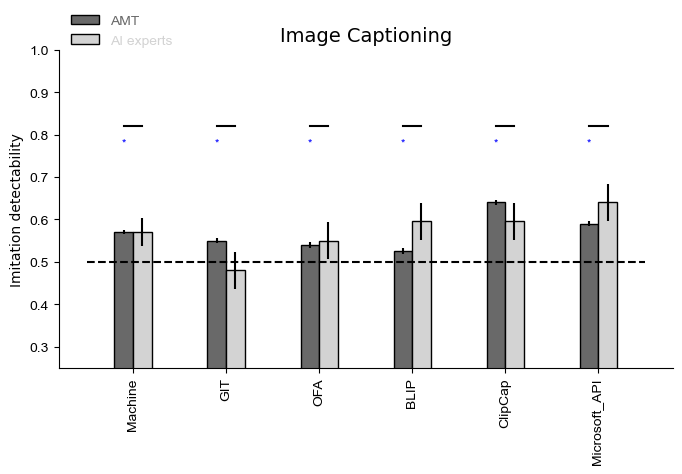

In [2]:
with open("./savedResults/compiled.json", 'r') as f:
    CompiledResults = json.load(f)

with open("./savedResults_elisa/compiled_AIexperts_may4.json", 'r') as f:
    AIexperts_results = json.load(f)

key = 'mturk' #choose from these choices: inlab, mturk
folderpath = './plots/Task1_' + key + '_' #for saving the plots

bonferroni = 1
if bonferroni == 1:
    correction = 'bonferroni'
else: 
    correction = 'normal'

condition_chosen_list = ['mturk', 'AIexperts'] #'inlab',
TextFilePath = './savedResults/Task1_' + key + '_' #not being used
plotpathname = './plots_elisa/Task1_' + key + '_mturk_vs_AIexeperts_' + correction #for saving the plots
facebarcolor = ['dimgray','lightgrey']

plot_res_demographics_with_bootstrap(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults, AIexperts_results)

In [ ]:
with open("./savedResults/compiled_test.json", 'r') as f:
    CompiledResults = json.load(f)

print(CompiledResults.keys())

['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 80 sampletime 40
bootstraptime 16 sampletime 8
bootstraptime 16 sampletime 8
bootstraptime 16 sampletime 8
bootstraptime 16 sampletime 8
bootstraptime 16 sampletime 8


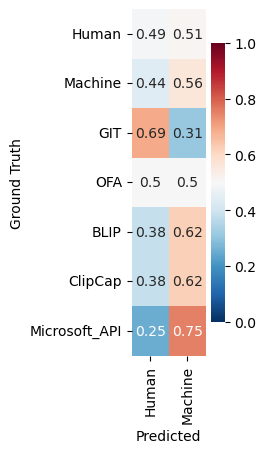

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


mean
[0.5249999761581421, 0.4000000059604645, 0.4950000047683716, 0.5550000071525574, 0.5550000071525574, 0.6200000047683716]
std
[0.04187937243963309, 0.10590188837285905, 0.12973220238605948, 0.0869085760206523, 0.1209676763062658, 0.08522431339559151]


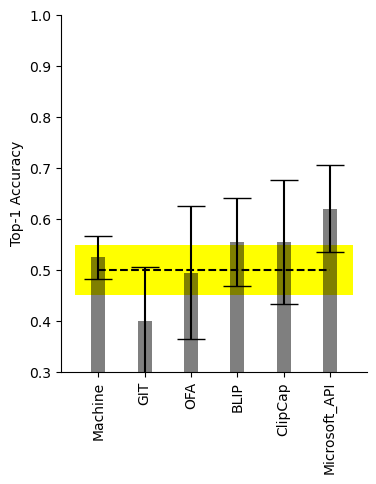

In [2]:
def plot_res_demographics_singleplot(condition_chosen, TextFilePath, condition_results, folderpath, saveflag):
    
    top1, top1std, result_conf_mat, dummy = ComputeBarStdConfMat(condition_results[condition_chosen])
    
    modelist = ['Human', 'Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    df_cm = pd.DataFrame(result_conf_mat, index = [i for i in modelist],
                  columns = [i for i in ['Human','Machine']])
    plt.figure(figsize = (1.2,4.5))
    
    if condition_chosen == 'machine':
        sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1, cbar=False)
    else:
        sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1)

    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    
    plotname = condition_chosen
    plt.savefig(folderpath + plotname + '_overall_confmat.eps', format='eps', bbox_inches='tight')
    plt.savefig(folderpath + plotname + '_overall_confmat.png', bbox_inches='tight')
    plt.show()
    
    if saveflag == 1:
        np.save(TextFilePath + "confmat.np", result_conf_mat)
        
    #data
    #x-axis
    years = list(range(1, len(modelist)-1))
    strtask = modelist[1:]
    #print(years)
    #print(strtask)

    # Figure Size
    fig, ax = plt.subplots()

    ax.add_patch(Rectangle((-0.5, 0.45), len(modelist)-1, 0.1,facecolor='yellow'))
    #bar chart properties
    #ax.bar(strtask, top1, color ='black', width = 0.3)
    ax.bar(strtask, top1, yerr=top1std,
       align='center', alpha=0.5, ecolor='black', capsize=10,
       color ='black', width = 0.3)

    print('mean')
    print(top1)
    print('std')
    print(top1std)
    
    plt.ylabel('Top-1 Accuracy')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

    plt.ylim(0.3, 1)
    #plt.xlim(0.5, len(years)+0.5)

    #draw chance 0.5 
    chancex =np.arange(len(years)+1)
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    #plt.legend()

    fig.tight_layout()

    fig.set_figwidth(3.5)
    fig.set_figheight(5)

    #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(folderpath + plotname + '_overall_barplot.eps', format='eps', bbox_inches='tight')
    plt.savefig(folderpath + plotname + '_overall_barplot.png', bbox_inches='tight')
    plt.show()



#======================Plot overall results (human judges)=======
with open("./savedResults_elisa/compiled_AIexperts_28apr.json", 'r') as f:
    CompiledResults = json.load(f)

key = 'AIexperts' #choose from these choices: inlab, mturk
TextFilePath = './savedResults_elisa/Task1_' + key + '_' #not being used
folderpath = './plots_elisa/Task1_' + key + '_' #for saving the plots
saveflag = 1 #save confmat for final plots
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (AI judges)=======
# with open("./savedResults/compiled_test.json", 'r') as f:
#     CompiledResults = json.load(f)

# key = 'machine' #choose from these choices: inlab, mturk
# TextFilePath = './savedResults/Task1_' + key + '_' #not being used
# folderpath = './plots/Task1_' + key + '_' #for saving the plots
# saveflag = 1
# plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)


['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 110 sampletime 55
bootstraptime 22 sampletime 11
bootstraptime 22 sampletime 11
bootstraptime 22 sampletime 11
bootstraptime 22 sampletime 11
bootstraptime 22 sampletime 11


/var/folders/5y/60d837ps00s6_lbr07dlqtwh0000gn/T/ipykernel_28560/1726727253.py:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


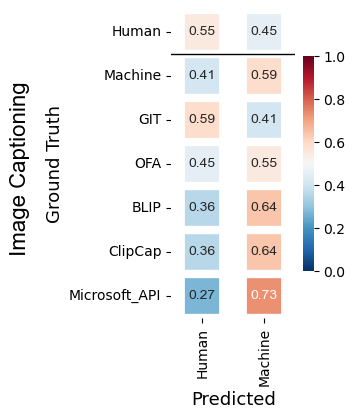

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


mean
[0.5699999928474426, 0.48000001907348633, 0.550000011920929, 0.5950000286102295, 0.5950000286102295, 0.6399999856948853]
std
[0.034592083679093256, 0.09168061046418922, 0.07864820789534825, 0.07788461497921803, 0.09971015299184836, 0.06484444143171578]


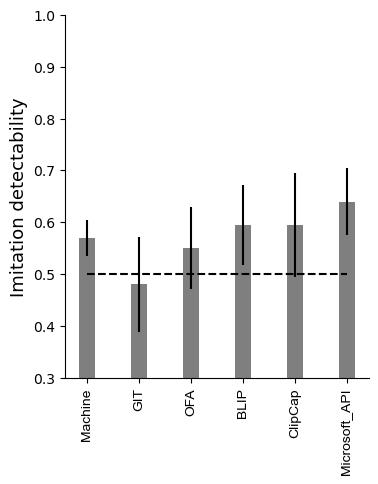

In [6]:
def plot_res_demographics_singleplot(condition_chosen, TextFilePath, condition_results, folderpath, saveflag):
    
    # Import necessary font libraries if not already imported
    from matplotlib import font_manager
    
    # Define Arial fonts (add these at the top of your script or in this function)
    # You'll need to adjust these paths to where your fonts are located
    arial_path = font_manager.findfont('Arial')
    arialbold_path = font_manager.findfont('Arial Bold')
    
    prop_arial = font_manager.FontProperties(fname=arial_path)
    prop_arialbold = font_manager.FontProperties(fname=arialbold_path)
    
    top1, top1std, result_conf_mat, dummy = ComputeBarStdConfMat(condition_results[condition_chosen])
    
    modelist = ['Human', 'Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    
    # PART 1: CONFUSION MATRIX
    df_cm = pd.DataFrame(result_conf_mat, index = [i for i in modelist],
                  columns = [i for i in ['Human','Machine']])
    plt.figure(figsize = (2, 4))
    
    # Create heatmap with custom settings
    ax = sn.heatmap(df_cm, annot=True, robust=True, cmap='RdBu_r', 
                   vmin=0, vmax=1, 
                   cbar=True if condition_chosen != 'machine' else False,
                   annot_kws={'ha':'center', 'fontproperties': prop_arial},
                   cbar_kws={"shrink": 0.7})
    
    # Add white grid lines between cells
    for i in range(df_cm.shape[0] + 1):
        ax.axhline(i, color='white', lw=6)
    for i in range(df_cm.shape[1] + 1):
        ax.axvline(i, color='white', lw=20)
    
    # Add black horizontal line (appears to be after the 3rd row)
    _ = ax.axhline(1, color='black', lw=1)
    
    # Set labels with custom font
    plt.xlabel("Predicted", weight='bold', fontproperties=prop_arialbold, fontsize=13)
    plt.ylabel("Ground Truth", weight='bold', fontproperties=prop_arialbold, fontsize=13)
    
    # Add "Conversations" text
    plt.text(-2.6, 5.5, "Image Captioning", fontproperties=prop_arial, fontsize=16, rotation=90)
    
    # Set x tick labels rotation
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
    
    # Save and display
    plt.tight_layout()
    plotname = condition_chosen
    plt.savefig(folderpath + plotname + '_overall_confmat.eps', format='eps', bbox_inches='tight')
    plt.savefig(folderpath + plotname + '_overall_confmat.png', bbox_inches='tight')
    plt.show()
    
    if saveflag == 1:
        np.save(TextFilePath + "confmat.np", result_conf_mat)
    
    # PART 2: BAR PLOT 
    # (keeping most of your original code but adjusting for consistency)
    
    # Data preparation
    years = list(range(1, len(modelist)-1))
    strtask = modelist[1:]
    
    # Create figure and axes
    fig, ax = plt.subplots()
    
    # Add yellow rectangle
    #ax.add_patch(plt.Rectangle((-0.5, 0.45), len(modelist)-1, 0.1, facecolor='yellow'))
    
    # Bar chart
    ax.bar(strtask, top1, yerr=top1std,
           align='center', alpha=0.5, ecolor='black', capsize=0,
           color='black', width=0.3)
    
    print('mean')
    print(top1)
    print('std')
    print(top1std)
    
    # Labels and formatting
    plt.ylabel('Imitation detectability', weight='bold', fontproperties=prop_arialbold, fontsize=13)
    plt.xticks(rotation=90, fontproperties=prop_arial)
    
    plt.ylim(0.3, 1)
    
    # Draw chance line
    chancex = np.arange(len(years)+1)
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    
    # Figure size and layout
    fig.tight_layout()
    fig.set_figwidth(3.5)
    fig.set_figheight(5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save and display
    plt.savefig(folderpath + plotname + '_overall_barplot.eps', format='eps', bbox_inches='tight')
    plt.savefig(folderpath + plotname + '_overall_barplot.png', bbox_inches='tight')
    plt.show()

# Usage remains the same
with open("./savedResults_elisa/compiled_AIexperts_may4.json", 'r') as f:
    CompiledResults = json.load(f)

key = 'AIexperts' 
TextFilePath = './savedResults_elisa/Task1_' + key + '_'
folderpath = './plots_elisa/Task1_' + key + '_'
saveflag = 1
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)